In [15]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [16]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [17]:
"""
To see how to train, ref the below links:
https://github.com/pytorch/examples/tree/master/mnist
and
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

"""
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        #return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(),])),
                   batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [18]:
import torch
import operator as op
import functools as ft


'''reduce_* helper functions reduce tensors on all dimensions but the first.
They are intended to be used on batched tensors where dim 0 is the batch dim.
'''


def reduce_sum(x, keepdim=True):
    # silly PyTorch, when will you get proper reducing sums/means?
    for a in reversed(range(1, x.dim())):
        x = x.sum(a, keepdim=keepdim)
    return x


def reduce_mean(x, keepdim=True):
    numel = ft.reduce(op.mul, x.size()[1:])
    x = reduce_sum(x, keepdim=keepdim)
    return x / numel


def reduce_min(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.min(a, keepdim=keepdim)[0]
    return x


def reduce_max(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.max(a, keepdim=keepdim)[0]
    return x


def torch_arctanh(x, eps=1e-6):
    x *= (1. - eps)
    return (torch.log((1 + x) / (1 - x))) * 0.5


def l2r_dist(x, y, keepdim=True, eps=1e-8):
    d = (x - y)**2
    d = reduce_sum(d, keepdim=keepdim)
    d += eps  # to prevent infinite gradient at 0
    return d.sqrt()


def l2_dist(x, y, keepdim=True):
    d = (x - y)**2
    return reduce_sum(d, keepdim=keepdim)


def l1_dist(x, y, keepdim=True):
    d = torch.abs(x - y)
    return reduce_sum(d, keepdim=keepdim)


def l2_norm(x, keepdim=True):
    norm = reduce_sum(x*x, keepdim=keepdim)
    return norm.sqrt()


def l1_norm(x, keepdim=True):
    return reduce_sum(x.abs(), keepdim=keepdim)


def rescale(x, x_min=-1., x_max=1.):
    return x * (x_max - x_min) + x_min


def tanh_rescale(x, x_min=-1., x_max=1.):
    return (torch.tanh(x) + 1) * 0.5 * (x_max - x_min) + x_min

In [19]:
"""PyTorch Carlini and Wagner L2 attack algorithm.

Based on paper by Carlini & Wagner, https://arxiv.org/abs/1608.04644 and a reference implementation at
https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py
"""
import os
import sys
import torch
import numpy as np
from torch import optim
from torch import autograd
#from .helpers import *


class AttackCarliniWagnerL2:

    def __init__(self, targeted=True, search_steps=None, max_steps=None, cuda=True, debug=False):
        self.debug = debug
        self.targeted = targeted
        #self.num_classes = 1000
        self.num_classes = 10
        self.confidence = 0  # FIXME need to find a good value for this, 0 value used in paper not doing much...
        self.initial_const = 0.1  # bumped up from default of .01 in reference code
        self.binary_search_steps = search_steps or 5
        self.repeat = self.binary_search_steps >= 10
        self.max_steps = max_steps or 1000
        self.abort_early = True
        self.clip_min = -1.
        self.clip_max = 1.
        self.cuda = cuda
        self.clamp_fn = 'tanh'  # set to something else perform a simple clamp instead of tanh
        self.init_rand = False  # an experiment, does a random starting point help?

    def _compare(self, output, target):
        if not isinstance(output, (float, int, np.int64)):
            output = np.copy(output)
            if self.targeted:
                output[target] -= self.confidence
            else:
                output[target] += self.confidence
            output = np.argmax(output)
        if self.targeted:
            return output == target
        else:
            return output != target

    def _loss(self, output, target, dist, scale_const):
        # compute the probability of the label class versus the maximum other
        
        # for the targeted attack, real will contain the current logit values for the targeted class
        # This basically tell us what is the current probability of the image being classified as the target class
        # multiplying by one hot encoded target ensures that other (index != target) logit values become 0
        # sum(1) simply gives us the logit value of the target class
        real = (target * output).sum(1)
        
        # indices other than target class will have their logit values, target index will have -10000
        # takes the maximum value when we suppress the logit of the targeted class
        # this will give the logit of the most likely other class
        # in the first run, this would most likely be the prob of the true class
        other = ((1. - target) * output - target * 10000.).max(1)[0]
        
        print('output: ', output)
        print('real: ', real)
        print('other: ', other)
        
        print('dist shape: ', dist.shape)
        print('dist: ', dist)
        
        if self.targeted:
            # if targeted, optimize for making the other class most likely
            loss1 = torch.clamp(other - real + self.confidence, min=0.)  # equiv to max(..., 0.)
        else:
            # if non-targeted, optimize for making this class least likely.
            loss1 = torch.clamp(real - other + self.confidence, min=0.)  # equiv to max(..., 0.)
        
        loss1 = torch.sum(scale_const * loss1)
        loss2 = dist.sum()
        
        print('loss2 which is dist.sum: ', loss2)

        loss = loss1 + loss2
        print('loss: ', loss)
        
        return loss

    def _optimize(self, optimizer, model, input_var, modifier_var, target_var, scale_const_var, input_orig=None):
        # apply modifier and clamp resulting image to keep bounded from clip_min to clip_max
        if self.clamp_fn == 'tanh':
            input_adv = tanh_rescale(modifier_var + input_var, self.clip_min, self.clip_max)
        else:
            input_adv = torch.clamp(modifier_var + input_var, self.clip_min, self.clip_max)

        output = model(input_adv)

        # distance to the original input data
        if input_orig is None:
            dist = l2_dist(input_adv, input_var, keepdim=False)
        else:
            dist = l2_dist(input_adv, input_orig, keepdim=False)
            
            

        loss = self._loss(output, target_var, dist, scale_const_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_np = loss.data[0] #throws error
        loss_np = loss.data
        dist_np = dist.data.cpu().numpy()
        output_np = output.data.cpu().numpy()
        input_adv_np = input_adv.data.permute(0, 2, 3, 1).cpu().numpy()  # back to BHWC for numpy consumption
        return loss_np, dist_np, output_np, input_adv_np

    def run(self, model, input, target, batch_idx=0):
        batch_size = input.size(0)
        print('batch size: ', batch_size)
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        scale_const = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # python/numpy placeholders for the overall best l2, label score, and adversarial image
        o_best_l2 = [1e10] * batch_size
        o_best_score = [-1] * batch_size
        o_best_attack = input.permute(0, 2, 3, 1).cpu().numpy()

        # setup input (image) variable, clamp/scale as necessary
        if self.clamp_fn == 'tanh':
            # convert to tanh-space, input already int -1 to 1 range, does it make sense to do
            # this as per the reference implementation or can we skip the arctanh?
            input_var = autograd.Variable(torch_arctanh(input), requires_grad=False)
            input_orig = tanh_rescale(input_var, self.clip_min, self.clip_max)
        else:
            input_var = autograd.Variable(input, requires_grad=False)
            input_orig = None

        # setup the target variable, we need it to be in one-hot form for the loss function
        target_onehot = torch.zeros(target.size() + (self.num_classes,))
        if self.cuda:
            target_onehot = target_onehot.cuda()
        target_onehot.scatter_(1, target.unsqueeze(1), 1.)
        
        #target_onehot will have a 1 at the index of the targeted class (in the case of targeted attack)
        print('target_onehot: ', target_onehot)
        
        target_var = autograd.Variable(target_onehot, requires_grad=False)

        # setup the modifier variable, this is the variable we are optimizing over
        modifier = torch.zeros(input_var.size()).float()
        if self.init_rand:
            # Experiment with a non-zero starting point...
            modifier = torch.normal(means=modifier, std=0.001)
        if self.cuda:
            modifier = modifier.cuda()
        modifier_var = autograd.Variable(modifier, requires_grad=True)

        optimizer = optim.Adam([modifier_var], lr=0.0005)

        for search_step in range(self.binary_search_steps):
            print('Batch: {0:>3}, search step: {1}'.format(batch_idx, search_step))
            if self.debug:
                print('Const:')
                for i, x in enumerate(scale_const):
                    print(i, x)
            best_l2 = [1e10] * batch_size
            best_score = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and search_step == self.binary_search_steps - 1:
                scale_const = upper_bound

            scale_const_tensor = torch.from_numpy(scale_const).float()
            if self.cuda:
                scale_const_tensor = scale_const_tensor.cuda()
            scale_const_var = autograd.Variable(scale_const_tensor, requires_grad=False)

            prev_loss = 1e6
            for step in range(self.max_steps):
                # perform the attack
                loss, dist, output, adv_img = self._optimize(
                    optimizer,
                    model,
                    input_var,
                    modifier_var,
                    target_var,
                    scale_const_var,
                    input_orig)

                if step % 100 == 0 or step == self.max_steps - 1:
                    print('Step: {0:>4}, loss: {1:6.4f}, dist: {2:8.5f}, modifier mean: {3:.5e}'.format(
                        step, loss, dist.mean(), modifier_var.data.mean()))

                if self.abort_early and step % (self.max_steps // 10) == 0:
                    if loss > prev_loss * .9999:
                        print('Aborting early...')
                        break
                    prev_loss = loss

                # update best result found
                for i in range(batch_size):
                    target_label = target[i]
                    output_logits = output[i]
                    output_label = np.argmax(output_logits)
                    di = dist[i]
                    if self.debug:
                        if step % 100 == 0:
                            print('{0:>2} dist: {1:.5f}, output: {2:>3}, {3:5.3}, target {4:>3}'.format(
                                i, di, output_label, output_logits[output_label], target_label))
                    if di < best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best step,  prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, best_l2[i], di))
                        best_l2[i] = di
                        best_score[i] = output_label
                    if di < o_best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best total, prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, o_best_l2[i], di))
                        o_best_l2[i] = di
                        o_best_score[i] = output_label
                        o_best_attack[i] = adv_img[i]

                sys.stdout.flush()
                # end inner step loop

            # adjust the constants
            batch_failure = 0
            batch_success = 0
            for i in range(batch_size):
                if self._compare(best_score[i], target[i]) and best_score[i] != -1:
                    # successful, do binary search and divide const by two
                    upper_bound[i] = min(upper_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    if self.debug:
                        print('{0:>2} successful attack, lowering const to {1:.3f}'.format(
                            i, scale_const[i]))
                else:
                    # failure, multiply by 10 if no solution found
                    # or do binary search with the known upper bound
                    lower_bound[i] = max(lower_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        scale_const[i] *= 10
                    if self.debug:
                        print('{0:>2} failed attack, raising const to {1:.3f}'.format(
                            i, scale_const[i]))
                if self._compare(o_best_score[i], target[i]) and o_best_score[i] != -1:
                    batch_success += 1
                else:
                    batch_failure += 1

            print('Num failures: {0:2d}, num successes: {1:2d}\n'.format(batch_failure, batch_success))
            sys.stdout.flush()
            # end outer search loop

        return o_best_attack


In [20]:
TARGETED = True
MAX_STEPS = 1000
SEARCH_STEPS = 6
NO_CUDA = False
DEBUG = False

attack = AttackCarliniWagnerL2(
        targeted=TARGETED,
        max_steps=MAX_STEPS,
        search_steps=SEARCH_STEPS,
        cuda=not NO_CUDA,
        debug=DEBUG)

In [21]:
#for batch_idx, (input, target) in enumerate(loader):
    
#     input = input.cuda()
#     target = target.cuda()

#     input_adv = attack.run(model, input, target, batch_idx)

#     start_index = args.batch_size * batch_idx
#     indices = list(range(start_index, start_index + input.size(0)))
#     for filename, o in zip(dataset.filenames(indices, basename=True), input_adv):
#         output_file = os.path.join(args.output_dir, filename)
#         imsave(output_file, (o + 1.0) * 0.5, format='png')

In [22]:
loader = test_loader

a,b = iter(loader).next()
a=a.cuda()

In [23]:
torch.min(a)

tensor(0., device='cuda:0')

In [24]:
loader = test_loader

iterations = 0
thresh_on_iterations = 1

success_record = []

for batch_idx, (input_tensor, input_label) in enumerate(loader):
    print('\n\n-------iteration: {}----------'.format(iterations))
    
    # clean image
    input_tensor = input_tensor.cuda()
    
    # original label for the clean image
    input_label = input_label.cuda()
    
    pred_input = model(input_tensor)
    pred_prob_input = F.softmax(pred_input, dim=1)
    print('prediction of adversarial sample: {} with probability: {}'
          .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))
    
    # if the attack is targeted, we will target the next class modulo number of classes
    if TARGETED == True:
        target = (input_label+1)%10
    # else the target is kept as the original label as per attack design
    else:
        target = input_label
    
    # result obtained is a numpy array
    adversarial_img = attack.run(model, input_tensor, target, batch_idx)
    
    # reshape
    adversarial_img = np.transpose(adversarial_img, (0,3,1,2))
    
    # conver to torch tensor
    adversarial_tensor = torch.from_numpy(adversarial_img).cuda()
    
    # obtain the prediction by the model
    pred_adv = model(adversarial_tensor)
    pred_prob_adv = F.softmax(pred_adv, dim=1)
    print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))

    
    clean_label = input_label.item()
    #pred_adv_label = torch.max(pred_adv, 1)[1].item()
    pred_adv_label = torch.argmax(pred_prob_adv)
    
    print('Original label of the clean image is: {} and predicted label of the adversarial image is {}'\
          .format(clean_label,pred_adv_label))
    
    result = 0
    if TARGETED:
        if pred_adv_label == target.item():
            result = 1
    else:
        if pred_adv_label != clean_label:
            result = 1
    
    success_record.append(result)
    
    iterations += 1
    if iterations == thresh_on_iterations:
        break



-------iteration: 0----------
prediction of adversarial sample: 7 with probability: 0.8430033326148987
batch size:  1
target_onehot:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')
Batch:   0, search step: 0
output:  tensor([[-2.5745, -0.1711,  2.2728,  1.7123, -1.7103, -2.5520, -5.9087,  4.6974,
         -0.3926,  1.1996]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3926], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.6974], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 0.5090, dist:  0.00000, modifier mean: -3.22174e-06
output:  tensor([[-2.5691, -0.1724,  2.2685,  1.7099, -1.7085, -2.5463, -5.8980,  4.6862,
         -0.3895,  1.1983]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor(

output:  tensor([[-2.5055, -0.1953,  2.2170,  1.6851, -1.6914, -2.4807, -5.7814,  4.5596,
         -0.3502,  1.1911]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3502], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5596], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0072], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0072, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.5029, -0.1965,  2.2148,  1.6839, -1.6903, -2.4780, -5.7764,  4.5540,
         -0.3482,  1.1909]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3482], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5540], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0077], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0077, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(0.0119, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4853, -0.2103,  2.1969,  1.6744, -1.6784, -2.4565, -5.7369,  4.5063,
         -0.3257,  1.1935]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3257], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5063], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0120], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0120, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4848, -0.2111,  2.1961,  1.6742, -1.6778, -2.4556, -5.7355,  4.5046,
         -0.3247,  1.1938]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3247], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5046], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

other:  tensor([4.4870], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0140], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0140, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4794, -0.2183,  2.1875,  1.6718, -1.6713, -2.4458, -5.7196,  4.4861,
         -0.3162,  1.1960]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3162], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4861], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0141], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0141, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4792, -0.2185,  2.1872,  1.6717, -1.6710, -2.4455, -5.7190,  4.4855,
         -0.3158,  1.1961]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4777, -0.2188,  2.1857,  1.6706, -1.6691, -2.4428, -5.7137,  4.4793,
         -0.3130,  1.1950]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4793], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0147], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0147, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4776, -0.2187,  2.1857,  1.6706, -1.6691, -2.4426, -5.7135,  4.4790,
         -0.3129,  1.1949]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3129], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4790], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0147], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0147, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(0.0153, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4768, -0.2183,  2.1847,  1.6708, -1.6678, -2.4399, -5.7078,  4.4719,
         -0.3095,  1.1930]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3095], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4719], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0154], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0154, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4768, -0.2183,  2.1849,  1.6708, -1.6676, -2.4398, -5.7074,  4.4714,
         -0.3091,  1.1928]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3091], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4714], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

loss:  tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4752, -0.2183,  2.1836,  1.6690, -1.6663, -2.4386, -5.7046,  4.4689,
         -0.3087,  1.1923]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3087], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4689], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0156], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0156, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4750, -0.2183,  2.1834,  1.6689, -1.6663, -2.4385, -5.7044,  4.4687,
         -0.3087,  1.1923]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3087], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4687], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0157], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

dist:  tensor([0.0158], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0158, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4742, -0.2182,  2.1829,  1.6686, -1.6659, -2.4373, -5.7024,  4.4666,
         -0.3079,  1.1916]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3079], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4666], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0158], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0158, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4742, -0.2182,  2.1829,  1.6686, -1.6659, -2.4372, -5.7023,  4.4665,
         -0.3078,  1.1916]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3078], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4665], device

real:  tensor([-0.3074], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4647], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0160], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0160, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4732, -0.2181,  2.1821,  1.6681, -1.6655, -2.4361, -5.7004,  4.4646,
         -0.3073,  1.1911]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3073], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4646], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0160], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0160, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4731, -0.2183,  2.1820,  1.6681, -1.6655, -2.4360, -5.7003,  4.4644,
       

loss2 which is dist.sum:  tensor(0.0163, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4718, -0.2188,  2.1810,  1.6679, -1.6654, -2.4344, -5.6978,  4.4614,
         -0.3059,  1.1911]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3059], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4614], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0163], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0163, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4717, -0.2188,  2.1810,  1.6679, -1.6655, -2.4343, -5.6977,  4.4612,
         -0.3059,  1.1910]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3059], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4612], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

output:  tensor([[-2.4696, -0.2191,  2.1800,  1.6670, -1.6655, -2.4326, -5.6946,  4.4578,
         -0.3052,  1.1904]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3052], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4578], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0166], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0166, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4695, -0.2191,  2.1800,  1.6669, -1.6656, -2.4326, -5.6944,  4.4576,
         -0.3052,  1.1903]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3052], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4576], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0166], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0166, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(0.0168, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4684, -0.2193,  2.1789,  1.6660, -1.6649, -2.4315, -5.6925,  4.4558,
         -0.3047,  1.1902]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3047], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4558], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0168], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0168, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4683, -0.2193,  2.1789,  1.6660, -1.6649, -2.4315, -5.6925,  4.4557,
         -0.3047,  1.1902]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3047], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4557], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

other:  tensor([4.4546], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0169], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0169, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4676, -0.2194,  2.1783,  1.6657, -1.6647, -2.4308, -5.6913,  4.4545,
         -0.3043,  1.1900]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3043], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4545], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0169], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0169, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4675, -0.2194,  2.1783,  1.6656, -1.6647, -2.4308, -5.6913,  4.4545,
         -0.3043,  1.1900]], device='cuda:0', grad_fn=<AddmmBackward>)
re

loss2 which is dist.sum:  tensor(0.0170, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4670, -0.2194,  2.1780,  1.6653, -1.6646, -2.4304, -5.6906,  4.4538,
         -0.3042,  1.1899]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3042], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4538], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0170], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0170, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4670, -0.2195,  2.1780,  1.6653, -1.6647, -2.4304, -5.6906,  4.4538,
         -0.3042,  1.1899]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3042], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4538], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

loss:  tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4665, -0.2195,  2.1777,  1.6652, -1.6646, -2.4299, -5.6898,  4.4530,
         -0.3040,  1.1898]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3040], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4530], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0170], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0170, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4665, -0.2195,  2.1776,  1.6651, -1.6646, -2.4299, -5.6898,  4.4530,
         -0.3040,  1.1898]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3040], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4530], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0170], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

loss2 which is dist.sum:  tensor(0.0170, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4661, -0.2193,  2.1775,  1.6649, -1.6645, -2.4296, -5.6891,  4.4523,
         -0.3039,  1.1895]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3039], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4523], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0170], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0170, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4659, -0.2194,  2.1773,  1.6648, -1.6645, -2.4295, -5.6890,  4.4522,
         -0.3039,  1.1895]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3039], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4522], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

loss2 which is dist.sum:  tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4655, -0.2194,  2.1772,  1.6646, -1.6646, -2.4293, -5.6885,  4.4517,
         -0.3038,  1.1894]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3038], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4517], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4655, -0.2195,  2.1771,  1.6646, -1.6646, -2.4293, -5.6885,  4.4517,
         -0.3038,  1.1894]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3038], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4517], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

dist:  tensor([0.0171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4650, -0.2194,  2.1768,  1.6643, -1.6645, -2.4289, -5.6879,  4.4512,
         -0.3037,  1.1893]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3037], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4649, -0.2194,  2.1768,  1.6643, -1.6645, -2.4289, -5.6878,  4.4511,
         -0.3036,  1.1893]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3036], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4511], device

real:  tensor([-0.3035], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4507], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4648, -0.2194,  2.1768,  1.6642, -1.6645, -2.4287, -5.6875,  4.4507,
         -0.3035,  1.1892]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3035], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4507], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4647, -0.2194,  2.1767,  1.6642, -1.6645, -2.4286, -5.6873,  4.4505,
       

output:  tensor([[-2.4643, -0.2194,  2.1765,  1.6640, -1.6645, -2.4284, -5.6868,  4.4501,
         -0.3034,  1.1891]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3034], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4501], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4644, -0.2194,  2.1765,  1.6640, -1.6645, -2.4284, -5.6869,  4.4501,
         -0.3034,  1.1891]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3034], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4501], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)

real:  tensor([-0.3033], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4496], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4637, -0.2195,  2.1761,  1.6637, -1.6644, -2.4280, -5.6862,  4.4494,
         -0.3034,  1.1891]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3034], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4494], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4636, -0.2195,  2.1760,  1.6636, -1.6644, -2.4279, -5.6861,  4.4494,
       

output:  tensor([[-2.4636, -0.2193,  2.1761,  1.6636, -1.6644, -2.4279, -5.6858,  4.4491,
         -0.3033,  1.1888]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3033], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4491], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4635, -0.2194,  2.1760,  1.6635, -1.6644, -2.4279, -5.6858,  4.4491,
         -0.3033,  1.1889]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3033], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4491], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)

loss:  tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4631, -0.2195,  2.1758,  1.6634, -1.6644, -2.4276, -5.6853,  4.4486,
         -0.3032,  1.1888]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3032], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4486], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4631, -0.2194,  2.1758,  1.6634, -1.6645, -2.4276, -5.6853,  4.4486,
         -0.3032,  1.1888]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3032], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4486], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

loss:  tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4629, -0.2194,  2.1757,  1.6632, -1.6644, -2.4275, -5.6849,  4.4482,
         -0.3031,  1.1887]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3031], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4482], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4629, -0.2194,  2.1757,  1.6632, -1.6644, -2.4274, -5.6849,  4.4482,
         -0.3031,  1.1887]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3031], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4482], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4626, -0.2194,  2.1755,  1.6631, -1.6644, -2.4272, -5.6844,  4.4477,
         -0.3030,  1.1886]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4477], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4624, -0.2194,  2.1754,  1.6630, -1.6643, -2.4271, -5.6843,  4.4476,
         -0.3030,  1.1886]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4476], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4622, -0.2193,  2.1754,  1.6628, -1.6643, -2.4269, -5.6838,  4.4472,
         -0.3029,  1.1884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3029], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4472], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4622, -0.2194,  2.1754,  1.6628, -1.6643, -2.4269, -5.6839,  4.4471,
         -0.3029,  1.1884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3029], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4471], device

output:  tensor([[-2.4619, -0.2194,  2.1751,  1.6627, -1.6643, -2.4267, -5.6835,  4.4468,
         -0.3029,  1.1884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3029], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4468], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4619, -0.2193,  2.1752,  1.6627, -1.6643, -2.4268, -5.6835,  4.4468,
         -0.3029,  1.1884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3029], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4468], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4463], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4615, -0.2194,  2.1749,  1.6625, -1.6643, -2.4265, -5.6830,  4.4463,
         -0.3028,  1.1884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3028], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4463], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4614, -0.2193,  2.1750,  1.6625, -1.6643, -2.4265, -5.6830,  4.4463,
         -0.3028,  1.1883]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4612, -0.2194,  2.1748,  1.6622, -1.6643, -2.4264, -5.6826,  4.4460,
         -0.3027,  1.1882]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4460], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4611, -0.2194,  2.1747,  1.6622, -1.6643, -2.4263, -5.6825,  4.4458,
         -0.3027,  1.1882]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4458], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4456], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4608, -0.2193,  2.1746,  1.6622, -1.6643, -2.4261, -5.6821,  4.4455,
         -0.3027,  1.1881]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4455], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4607, -0.2193,  2.1745,  1.6621, -1.6642, -2.4260, -5.6820,  4.4454,
         -0.3026,  1.1881]], device='cuda:0', grad_fn=<AddmmBackward>)
re

loss:  tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4606, -0.2193,  2.1745,  1.6620, -1.6642, -2.4259, -5.6818,  4.4451,
         -0.3025,  1.1881]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3025], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4451], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4606, -0.2193,  2.1745,  1.6620, -1.6642, -2.4259, -5.6818,  4.4451,
         -0.3025,  1.1881]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3025], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4451], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

other:  tensor([4.4448], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4604, -0.2194,  2.1744,  1.6618, -1.6642, -2.4258, -5.6814,  4.4448,
         -0.3024,  1.1881]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3024], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4448], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4604, -0.2193,  2.1744,  1.6618, -1.6642, -2.4258, -5.6814,  4.4448,
         -0.3024,  1.1880]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4600, -0.2193,  2.1741,  1.6616, -1.6641, -2.4255, -5.6809,  4.4442,
         -0.3024,  1.1880]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3024], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4442], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4600, -0.2193,  2.1741,  1.6616, -1.6641, -2.4255, -5.6808,  4.4441,
         -0.3024,  1.1879]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3024], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4441], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4597, -0.2192,  2.1740,  1.6615, -1.6641, -2.4253, -5.6805,  4.4438,
         -0.3023,  1.1877]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3023], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4438], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4597, -0.2192,  2.1740,  1.6615, -1.6642, -2.4253, -5.6804,  4.4438,
         -0.3024,  1.1877]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3024], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4438], device

output:  tensor([[-2.4594, -0.2192,  2.1738,  1.6613, -1.6641, -2.4251, -5.6800,  4.4434,
         -0.3022,  1.1877]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3022], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4434], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4594, -0.2192,  2.1738,  1.6612, -1.6640, -2.4251, -5.6800,  4.4434,
         -0.3023,  1.1877]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3023], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4434], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4591, -0.2192,  2.1736,  1.6611, -1.6640, -2.4248, -5.6795,  4.4429,
         -0.3022,  1.1876]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3022], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4429], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4591, -0.2193,  2.1736,  1.6612, -1.6640, -2.4248, -5.6795,  4.4429,
         -0.3022,  1.1876]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3022], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4429], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

real:  tensor([-0.3021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4425], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4587, -0.2193,  2.1733,  1.6609, -1.6640, -2.4246, -5.6790,  4.4425,
         -0.3021,  1.1876]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4425], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4586, -0.2193,  2.1732,  1.6608, -1.6640, -2.4246, -5.6789,  4.4424,
       

output:  tensor([[-2.4584, -0.2193,  2.1732,  1.6607, -1.6639, -2.4244, -5.6785,  4.4420,
         -0.3020,  1.1874]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3020], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4420], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4583, -0.2193,  2.1731,  1.6607, -1.6639, -2.4243, -5.6784,  4.4419,
         -0.3020,  1.1874]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3020], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4419], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[-2.4581, -0.2192,  2.1731,  1.6604, -1.6638, -2.4243, -5.6781,  4.4416,
         -0.3020,  1.1873]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3020], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4416], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4581, -0.2192,  2.1730,  1.6604, -1.6638, -2.4242, -5.6780,  4.4415,
         -0.3020,  1.1873]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3020], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4415], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)

real:  tensor([-0.3019], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4413], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4578, -0.2192,  2.1729,  1.6604, -1.6639, -2.4240, -5.6778,  4.4412,
         -0.3019,  1.1873]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3019], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4412], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4578, -0.2192,  2.1729,  1.6603, -1.6638, -2.4240, -5.6776,  4.4411,
       

output:  tensor([[-2.4574, -0.2193,  2.1726,  1.6601, -1.6638, -2.4237, -5.6771,  4.4406,
         -0.3018,  1.1872]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3018], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4406], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4573, -0.2193,  2.1725,  1.6601, -1.6637, -2.4237, -5.6770,  4.4406,
         -0.3018,  1.1872]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3018], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4406], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0175, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4403], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4573, -0.2192,  2.1726,  1.6601, -1.6637, -2.4236, -5.6767,  4.4402,
         -0.3017,  1.1870]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3017], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4402], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4572, -0.2192,  2.1725,  1.6600, -1.6637, -2.4235, -5.6767,  4.4402,
         -0.3017,  1.1870]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4568, -0.2192,  2.1723,  1.6598, -1.6637, -2.4233, -5.6763,  4.4398,
         -0.3017,  1.1870]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3017], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4398], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4568, -0.2192,  2.1723,  1.6598, -1.6637, -2.4234, -5.6763,  4.4399,
         -0.3017,  1.1870]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3017], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4399], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4564, -0.2192,  2.1720,  1.6595, -1.6636, -2.4230, -5.6757,  4.4393,
         -0.3016,  1.1869]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4393], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4565, -0.2192,  2.1721,  1.6595, -1.6636, -2.4231, -5.6758,  4.4393,
         -0.3016,  1.1869]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4393], device

real:  tensor([-0.3015], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4388], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4562, -0.2193,  2.1718,  1.6595, -1.6636, -2.4228, -5.6753,  4.4388,
         -0.3015,  1.1869]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3015], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4388], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4562, -0.2193,  2.1719,  1.6595, -1.6636, -2.4228, -5.6753,  4.4388,
       

dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4561, -0.2191,  2.1720,  1.6594, -1.6635, -2.4227, -5.6749,  4.4385,
         -0.3013,  1.1866]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3013], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4385], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0176], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0176, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4561, -0.2191,  2.1719,  1.6594, -1.6635, -2.4227, -5.6749,  4.4384,
         -0.3013,  1.1866]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3013], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4384], device

output:  tensor([[-2.4555, -0.2191,  2.1716,  1.6591, -1.6635, -2.4224, -5.6743,  4.4379,
         -0.3014,  1.1865]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3014], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4379], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4554, -0.2191,  2.1715,  1.6590, -1.6635, -2.4223, -5.6742,  4.4378,
         -0.3014,  1.1865]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3014], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4378], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4553, -0.2191,  2.1714,  1.6590, -1.6634, -2.4222, -5.6739,  4.4375,
         -0.3012,  1.1865]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3012], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4375], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4553, -0.2191,  2.1714,  1.6589, -1.6634, -2.4222, -5.6740,  4.4375,
         -0.3012,  1.1865]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3012], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4375], device

real:  tensor([-0.3011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4371], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4551, -0.2192,  2.1712,  1.6588, -1.6634, -2.4220, -5.6735,  4.4371,
         -0.3011,  1.1865]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4371], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4551, -0.2192,  2.1712,  1.6588, -1.6633, -2.4219, -5.6734,  4.4370,
       

output:  tensor([[-2.4548, -0.2191,  2.1711,  1.6587, -1.6633, -2.4217, -5.6730,  4.4366,
         -0.3010,  1.1863]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3010], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4366], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4547, -0.2191,  2.1710,  1.6586, -1.6634, -2.4217, -5.6730,  4.4366,
         -0.3011,  1.1863]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4366], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4361], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4543, -0.2191,  2.1708,  1.6585, -1.6633, -2.4214, -5.6724,  4.4361,
         -0.3011,  1.1862]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4361], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4544, -0.2190,  2.1709,  1.6585, -1.6633, -2.4214, -5.6724,  4.4361,
         -0.3010,  1.1861]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4542, -0.2191,  2.1708,  1.6583, -1.6632, -2.4213, -5.6720,  4.4356,
         -0.3009,  1.1860]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3009], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4356], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0178, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4541, -0.2191,  2.1707,  1.6583, -1.6633, -2.4212, -5.6720,  4.4356,
         -0.3009,  1.1860]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3009], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4356], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0178, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4352], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0178, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4537, -0.2191,  2.1705,  1.6581, -1.6632, -2.4210, -5.6715,  4.4352,
         -0.3008,  1.1860]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3008], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4352], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0178, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4537, -0.2191,  2.1705,  1.6581, -1.6631, -2.4210, -5.6715,  4.4352,
         -0.3008,  1.1860]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4536, -0.2191,  2.1705,  1.6580, -1.6632, -2.4209, -5.6712,  4.4348,
         -0.3007,  1.1859]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3007], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4348], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0178, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4536, -0.2191,  2.1704,  1.6580, -1.6632, -2.4208, -5.6712,  4.4348,
         -0.3006,  1.1859]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4348], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0178, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[-2.4532, -0.2190,  2.1702,  1.6577, -1.6630, -2.4206, -5.6705,  4.4342,
         -0.3006,  1.1857]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4342], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4532, -0.2191,  2.1701,  1.6577, -1.6630, -2.4205, -5.6705,  4.4341,
         -0.3006,  1.1858]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4341], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4339], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4529, -0.2190,  2.1700,  1.6576, -1.6630, -2.4203, -5.6701,  4.4338,
         -0.3005,  1.1856]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3005], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4338], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4528, -0.2190,  2.1700,  1.6575, -1.6630, -2.4203, -5.6700,  4.4338,
         -0.3006,  1.1856]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4526, -0.2190,  2.1698,  1.6574, -1.6629, -2.4202, -5.6697,  4.4335,
         -0.3005,  1.1856]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3005], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4335], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4526, -0.2190,  2.1698,  1.6574, -1.6630, -2.4201, -5.6697,  4.4334,
         -0.3005,  1.1855]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3005], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4334], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4524, -0.2191,  2.1697,  1.6573, -1.6628, -2.4199, -5.6692,  4.4329,
         -0.3003,  1.1855]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4329], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4523, -0.2191,  2.1697,  1.6573, -1.6629, -2.4198, -5.6692,  4.4328,
         -0.3003,  1.1854]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4328], device

output:  tensor([[-2.4520, -0.2190,  2.1695,  1.6571, -1.6629, -2.4197, -5.6688,  4.4325,
         -0.3002,  1.1854]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4325], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4520, -0.2190,  2.1695,  1.6570, -1.6628, -2.4197, -5.6687,  4.4324,
         -0.3002,  1.1854]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4324], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4320], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4516, -0.2191,  2.1691,  1.6568, -1.6627, -2.4193, -5.6681,  4.4319,
         -0.3002,  1.1853]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4319], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4516, -0.2190,  2.1692,  1.6568, -1.6627, -2.4193, -5.6681,  4.4319,
         -0.3002,  1.1852]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4515, -0.2190,  2.1692,  1.6569, -1.6628, -2.4192, -5.6679,  4.4316,
         -0.3001,  1.1851]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3001], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4316], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4514, -0.2190,  2.1691,  1.6568, -1.6627, -2.4191, -5.6677,  4.4315,
         -0.3001,  1.1852]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3001], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4315], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([4.4310], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4513, -0.2189,  2.1691,  1.6566, -1.6626, -2.4190, -5.6673,  4.4311,
         -0.2999,  1.1849]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4311], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4512, -0.2188,  2.1691,  1.6565, -1.6626, -2.4190, -5.6673,  4.4311,
         -0.3000,  1.1849]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[-2.4507, -0.2190,  2.1687,  1.6563, -1.6626, -2.4187, -5.6668,  4.4306,
         -0.2999,  1.1850]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4306], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0181], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0181, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4507, -0.2190,  2.1687,  1.6563, -1.6626, -2.4187, -5.6667,  4.4305,
         -0.2999,  1.1849]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4305], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0181], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0181, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0181], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0181, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4506, -0.2191,  2.1686,  1.6563, -1.6625, -2.4185, -5.6664,  4.4302,
         -0.2998,  1.1849]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2998], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4302], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0181], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0181, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.4506, -0.2190,  2.1686,  1.6563, -1.6626, -2.4185, -5.6664,  4.4302,
         -0.2998,  1.1848]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2998], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4302], device

Num failures:  1, num successes:  0

Batch:   0, search step: 1
output:  tensor([[-2.4504, -0.2189,  2.1686,  1.6561, -1.6625, -2.4183, -5.6660,  4.4298,
         -0.2997,  1.1846]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2997], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.4298], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0181], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0181, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.7476, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 4.7476, dist:  0.01812, modifier mean: -1.30753e-02
output:  tensor([[-2.4359, -0.2224,  2.1572,  1.6512, -1.6586, -2.4023, -5.6375,  4.3994,
         -0.2908,  1.1809]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.3994], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tenso

real:  tensor([-0.0559], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6547], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3794], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3794, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.0900, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.0666, -0.3368,  1.8574,  1.5233, -1.5535, -1.9959, -4.9131,  3.6088,
         -0.0412,  1.1100]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0412], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6088], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.4096], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.4096, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.0597, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-2.0449, -0.3450,  1.8400,  1.5166, -1.5497, -1.9732, -4.8738,  3.5649,
       

output:  tensor([[-1.8065, -0.4216,  1.6673,  1.4094, -1.5102, -1.7782, -4.5033,  3.1366,
          0.1182,  1.1089]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1182], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1366], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7515], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7515, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.7699, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.7947, -0.4261,  1.6586,  1.4038, -1.5079, -1.7689, -4.4860,  3.1159,
          0.1258,  1.1098]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1258], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1159], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7679], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7679, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.8957], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.9342], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.9342, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.6227, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.6463, -0.5072,  1.5305,  1.3472, -1.4852, -1.6477, -4.2947,  2.8839,
          0.2114,  1.1497]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2114], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8839], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.9427], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.9427, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.6152, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.6378, -0.5129,  1.5219,  1.3436, -1.4836, -1.6409, -4.2852,  2.8724,
          0.2156,  1.1538]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.5529, -0.5733,  1.4344,  1.3090, -1.4668, -1.5689, -4.1852,  2.7469,
          0.2677,  1.1983]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2677], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.7469], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0499], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0499, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5290, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.5489, -0.5765,  1.4301,  1.3070, -1.4655, -1.5654, -4.1801,  2.7402,
          0.2710,  1.2006]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2710], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.7402], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0561], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0561, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.6558], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1349], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1349, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4757, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.5002, -0.6204,  1.3775,  1.2782, -1.4426, -1.5213, -4.1130,  2.6516,
          0.3174,  1.2318]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3174], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6516], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1390], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1390, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4733, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.4981, -0.6227,  1.3747,  1.2762, -1.4408, -1.5195, -4.1101,  2.6476,
          0.3199,  1.2339]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.4693, -0.6552,  1.3368,  1.2571, -1.4196, -1.4914, -4.0722,  2.5917,
          0.3548,  1.2606]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3548], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5917], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2032], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2032, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4401, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.4674, -0.6575,  1.3343,  1.2563, -1.4184, -1.4894, -4.0699,  2.5880,
          0.3573,  1.2624]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3573], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5880], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2076, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([0.3935], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5277], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2686], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2686, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4028, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.4343, -0.6864,  1.3030,  1.2393, -1.4050, -1.4586, -4.0247,  2.5230,
          0.3964,  1.2828]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3964], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5230], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2737], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2737, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4003, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.4319, -0.6887,  1.3010,  1.2385, -1.4049, -1.4568, -4.0222,  2.5189,
         

output:  tensor([[-1.4032, -0.7100,  1.2764,  1.2240, -1.3992, -1.4341, -3.9919,  2.4727,
          0.4262,  1.3010]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4262], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4727], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.3299], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3299, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3763, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.4017, -0.7113,  1.2738,  1.2224, -1.3978, -1.4324, -3.9900,  2.4699,
          0.4281,  1.3026]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4281], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4699], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.3329], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3329, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([1.3936], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3936, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3447, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3818, -0.7569,  1.2087,  1.2093, -1.3760, -1.3907, -3.9703,  2.4118,
          0.4720,  1.3556]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4720], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4118], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.4017], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.4017, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3415, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3802, -0.7639,  1.2009,  1.2101, -1.3746, -1.3855, -3.9693,  2.4047,
          0.4777,  1.3626]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4777], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4047], device='

real:  tensor([0.5514], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.3158], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5281], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5281, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2925, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3678, -0.8580,  1.0891,  1.2128, -1.3353, -1.3115, -3.9516,  2.3102,
          0.5559,  1.4603]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5559], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.3102], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5355], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5355, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2898, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3671, -0.8627,  1.0835,  1.2128, -1.3328, -1.3076, -3.9499,  2.3046,
         

output:  tensor([[-1.3713, -0.8972,  1.0357,  1.2139, -1.2996, -1.2749, -3.9382,  2.2664,
          0.5928,  1.4985]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5928], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2664], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5832], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5832, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2568, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3718, -0.8984,  1.0331,  1.2133, -1.2974, -1.2735, -3.9378,  2.2653,
          0.5940,  1.5002]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5940], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2653], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5837], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5837, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([1.5901], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5901, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2337, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3774, -0.9108,  1.0005,  1.1974, -1.2647, -1.2579, -3.9296,  2.2522,
          0.6098,  1.5222]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6098], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2522], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5897], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5897, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2321, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3773, -0.9115,  0.9985,  1.1962, -1.2629, -1.2567, -3.9286,  2.2510,
          0.6108,  1.5232]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6108], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2510], device='

output:  tensor([[-1.3784, -0.9183,  0.9776,  1.1863, -1.2430, -1.2449, -3.9200,  2.2405,
          0.6187,  1.5341]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6187], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2405], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5982], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5982, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2201, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3787, -0.9183,  0.9766,  1.1854, -1.2417, -1.2447, -3.9200,  2.2408,
          0.6188,  1.5348]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6188], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2408], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5973], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5973, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(1.6011, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2127, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3763, -0.9218,  0.9633,  1.1787, -1.2308, -1.2367, -3.9118,  2.2322,
          0.6222,  1.5397]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6222], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2322], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6022], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6022, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2122, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3759, -0.9223,  0.9626,  1.1788, -1.2305, -1.2359, -3.9111,  2.2310,
          0.6226,  1.5399]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6226], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2310], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([0.6251], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2260], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6060], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6060, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2069, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3758, -0.9233,  0.9547,  1.1747, -1.2225, -1.2311, -3.9060,  2.2263,
          0.6248,  1.5423]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6248], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2263], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6052], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6052, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2067, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3755, -0.9236,  0.9543,  1.1744, -1.2223, -1.2307, -3.9054,  2.2256,
         

output:  tensor([[-1.3758, -0.9293,  0.9449,  1.1686, -1.2122, -1.2265, -3.9020,  2.2194,
          0.6314,  1.5484]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6314], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2194], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6101], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6101, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1982, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3761, -0.9301,  0.9439,  1.1679, -1.2109, -1.2263, -3.9022,  2.2193,
          0.6320,  1.5495]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6320], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2193], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6099], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6099, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.2137], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6162], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6162, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1860, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3803, -0.9419,  0.9283,  1.1558, -1.1891, -1.2215, -3.9003,  2.2127,
          0.6450,  1.5625]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6450], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1851, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3803, -0.9428,  0.9271,  1.1553, -1.1879, -1.2209, -3.8998,  2.2116,
          0.6460,  1.5632]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3834, -0.9532,  0.9102,  1.1444, -1.1688, -1.2161, -3.8994,  2.2064,
          0.6576,  1.5782]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6576], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2064], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6282], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6282, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1770, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3837, -0.9539,  0.9090,  1.1435, -1.1674, -1.2159, -3.8995,  2.2063,
          0.6583,  1.5794]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6583], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.2063], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6286], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6286, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([1.6386], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6386, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1701, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3842, -0.9645,  0.8901,  1.1333, -1.1505, -1.2093, -3.8969,  2.1985,
          0.6688,  1.5948]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6688], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1985], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6401], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6401, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1699, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3843, -0.9650,  0.8892,  1.1326, -1.1495, -1.2090, -3.8967,  2.1981,
          0.6694,  1.5955]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6694], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1981], device='

output:  tensor([[-1.3831, -0.9710,  0.8768,  1.1259, -1.1388, -1.2037, -3.8925,  2.1920,
          0.6747,  1.6036]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6747], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1920], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6474], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6474, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1647, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3834, -0.9711,  0.8767,  1.1252, -1.1380, -1.2040, -3.8928,  2.1925,
          0.6749,  1.6040]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6749], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1925], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6466], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6466, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.1885], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6499], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6499, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1602, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3823, -0.9757,  0.8681,  1.1213, -1.1316, -1.2001, -3.8904,  2.1883,
          0.6784,  1.6098]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6784], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1883], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6501], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6501, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1599, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3826, -0.9757,  0.8680,  1.1209, -1.1310, -1.2003, -3.8907,  2.1887,
          0.6786,  1.6102]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3813, -0.9782,  0.8617,  1.1175, -1.1259, -1.1969, -3.8875,  2.1850,
          0.6807,  1.6133]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6807], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1850], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6524], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6524, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1567, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3814, -0.9781,  0.8616,  1.1170, -1.1255, -1.1970, -3.8875,  2.1853,
          0.6807,  1.6134]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6807], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1853], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6518], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6518, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.1808], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6553], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6553, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1541, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3791, -0.9794,  0.8557,  1.1137, -1.1212, -1.1933, -3.8826,  2.1802,
          0.6825,  1.6149]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6825], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1802], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6561], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6561, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1538, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3791, -0.9796,  0.8553,  1.1135, -1.1209, -1.1932, -3.8827,  2.1801,
          0.6826,  1.6153]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3779, -0.9800,  0.8512,  1.1099, -1.1168, -1.1909, -3.8794,  2.1774,
          0.6838,  1.6165]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6838], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1774], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6576], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6576, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1512, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3775, -0.9804,  0.8506,  1.1100, -1.1167, -1.1904, -3.8789,  2.1766,
          0.6841,  1.6167]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6841], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1766], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6585], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6585, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(1.6578, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1489, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3772, -0.9802,  0.8473,  1.1068, -1.1134, -1.1892, -3.8774,  2.1759,
          0.6845,  1.6184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6845], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1759], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6575], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6575, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1489, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3770, -0.9804,  0.8469,  1.1067, -1.1133, -1.1889, -3.8770,  2.1753,
          0.6846,  1.6184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6846], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1753], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([2.1710], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6610], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6610, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1463, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3745, -0.9812,  0.8429,  1.1045, -1.1105, -1.1856, -3.8721,  2.1703,
          0.6860,  1.6184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6860], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1703], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6618], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6618, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1461, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3745, -0.9812,  0.8427,  1.1044, -1.1103, -1.1855, -3.8720,  2.1701,
          0.6861,  1.6185]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3731, -0.9818,  0.8398,  1.1029, -1.1084, -1.1833, -3.8688,  2.1667,
          0.6871,  1.6188]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6871], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1667], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6646], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6646, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1441, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3733, -0.9815,  0.8399,  1.1026, -1.1081, -1.1836, -3.8689,  2.1671,
          0.6870,  1.6188]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6870], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1671], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6638], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6638, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(1.6645, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1418, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3716, -0.9807,  0.8377,  1.1000, -1.1057, -1.1818, -3.8651,  2.1644,
          0.6872,  1.6179]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6872], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1644], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6646], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6646, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1417, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3717, -0.9806,  0.8379,  1.0998, -1.1056, -1.1819, -3.8653,  2.1646,
          0.6872,  1.6179]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6872], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1646], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

loss2 which is dist.sum:  tensor(1.6653, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1394, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3708, -0.9812,  0.8348,  1.0981, -1.1035, -1.1803, -3.8636,  2.1630,
          0.6877,  1.6192]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6877], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1630], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6641], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6641, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1393, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3708, -0.9810,  0.8348,  1.0978, -1.1033, -1.1803, -3.8634,  2.1630,
          0.6877,  1.6191]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6877], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1630], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([2.1595], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6663], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6663, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1373, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3694, -0.9809,  0.8323,  1.0959, -1.1011, -1.1783, -3.8601,  2.1601,
          0.6882,  1.6189]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6882], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1601], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6652], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6652, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1371, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3700, -0.9802,  0.8326,  1.0953, -1.1006, -1.1789, -3.8605,  2.1612,
          0.6878,  1.6188]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3681, -0.9807,  0.8303,  1.0945, -1.0996, -1.1764, -3.8572,  2.1572,
          0.6890,  1.6184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6890], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1572], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6667], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6667, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1349, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3679, -0.9806,  0.8302,  1.0944, -1.0997, -1.1763, -3.8570,  2.1570,
          0.6890,  1.6184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6890], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1570], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6667], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6667, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3672, -0.9803,  0.8285,  1.0926, -1.0978, -1.1754, -3.8551,  2.1558,
          0.6890,  1.6185]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6890], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1558], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6662], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6662, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1329, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3670, -0.9804,  0.8281,  1.0925, -1.0977, -1.1750, -3.8547,  2.1552,
          0.6892,  1.6186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6892], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1552], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6667], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6667, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.1533], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6667], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6667, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1306, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3660, -0.9795,  0.8270,  1.0906, -1.0961, -1.1741, -3.8524,  2.1540,
          0.6892,  1.6178]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6892], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1540], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6658], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6658, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1306, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3659, -0.9795,  0.8268,  1.0904, -1.0961, -1.1740, -3.8522,  2.1539,
          0.6891,  1.6177]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3655, -0.9798,  0.8246,  1.0892, -1.0942, -1.1726, -3.8507,  2.1522,
          0.6898,  1.6186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6898], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1522], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6660], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6660, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1285, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3652, -0.9800,  0.8241,  1.0893, -1.0941, -1.1721, -3.8502,  2.1514,
          0.6900,  1.6186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6900], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1514], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6670], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6670, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3636, -0.9794,  0.8230,  1.0876, -1.0931, -1.1711, -3.8475,  2.1495,
          0.6901,  1.6176]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6901], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1495], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6669], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6669, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1264, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3635, -0.9794,  0.8228,  1.0876, -1.0931, -1.1708, -3.8473,  2.1492,
          0.6901,  1.6176]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6901], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1492], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6671], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6671, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3622, -0.9795,  0.8209,  1.0867, -1.0921, -1.1690, -3.8445,  2.1461,
          0.6909,  1.6173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6909], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1461], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6691], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6691, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1243, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3623, -0.9793,  0.8209,  1.0863, -1.0917, -1.1691, -3.8445,  2.1464,
          0.6908,  1.6173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1464], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6685, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3615, -0.9787,  0.8192,  1.0845, -1.0900, -1.1681, -3.8427,  2.1455,
          0.6906,  1.6173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6906], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1455], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6671], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6671, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1219, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3614, -0.9787,  0.8191,  1.0845, -1.0900, -1.1679, -3.8425,  2.1451,
          0.6907,  1.6172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6907], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1451], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6675], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6675, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3603, -0.9783,  0.8179,  1.0831, -1.0888, -1.1669, -3.8405,  2.1436,
          0.6910,  1.6168]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6910], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1436], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6673], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6673, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1198, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3603, -0.9784,  0.8176,  1.0830, -1.0887, -1.1669, -3.8405,  2.1435,
          0.6911,  1.6171]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6911], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1435], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6673], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6673, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3591, -0.9779,  0.8162,  1.0814, -1.0873, -1.1654, -3.8378,  2.1413,
          0.6914,  1.6163]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6914], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1413], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6678], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6678, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1177, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3588, -0.9781,  0.8157,  1.0816, -1.0873, -1.1648, -3.8369,  2.1401,
          0.6917,  1.6162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6917], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1401], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6693], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6693, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3577, -0.9773,  0.8147,  1.0800, -1.0863, -1.1641, -3.8351,  2.1390,
          0.6916,  1.6156]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6916], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1390], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6684], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6684, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1157, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3576, -0.9771,  0.8147,  1.0798, -1.0861, -1.1641, -3.8348,  2.1388,
          0.6916,  1.6155]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6916], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1388], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6683], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6683, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3567, -0.9771,  0.8129,  1.0786, -1.0847, -1.1627, -3.8326,  2.1367,
          0.6920,  1.6154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6920], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1367], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6690], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6690, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1137, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3567, -0.9770,  0.8130,  1.0785, -1.0847, -1.1627, -3.8327,  2.1369,
          0.6920,  1.6154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6920], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1369], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6685, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3557, -0.9773,  0.8115,  1.0774, -1.0836, -1.1616, -3.8310,  2.1353,
          0.6924,  1.6154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6924], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1353], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6686], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6686, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1115, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3557, -0.9771,  0.8117,  1.0771, -1.0834, -1.1617, -3.8311,  2.1355,
          0.6923,  1.6153]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6923], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1355], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6681], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6681, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.1342], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6677], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6677, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1095, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3550, -0.9766,  0.8102,  1.0755, -1.0817, -1.1606, -3.8291,  2.1342,
          0.6924,  1.6150]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6924], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1342], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6677], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6677, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1094, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3545, -0.9769,  0.8098,  1.0756, -1.0818, -1.1601, -3.8285,  2.1332,
          0.6927,  1.6150]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3536, -0.9767,  0.8082,  1.0744, -1.0809, -1.1590, -3.8270,  2.1319,
          0.6930,  1.6151]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6930], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1319], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6685, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1074, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3533, -0.9770,  0.8078,  1.0745, -1.0809, -1.1585, -3.8264,  2.1309,
          0.6933,  1.6151]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6933], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1309], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6698], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6698, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([1.6676], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6676, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1055, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3522, -0.9760,  0.8066,  1.0727, -1.0794, -1.1574, -3.8240,  2.1297,
          0.6929,  1.6142]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6929], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1297], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6685, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1053, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3518, -0.9764,  0.8059,  1.0731, -1.0795, -1.1566, -3.8233,  2.1285,
          0.6932,  1.6143]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6932], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1285], device='

dist:  tensor([1.6675], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6675, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1032, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3507, -0.9751,  0.8058,  1.0717, -1.0787, -1.1559, -3.8210,  2.1278,
          0.6920,  1.6123]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6920], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1278], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6674], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6674, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1032, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3503, -0.9752,  0.8054,  1.0718, -1.0788, -1.1554, -3.8205,  2.1271,
          0.6921,  1.6122]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6921], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1271], device='

output:  tensor([[-1.3490, -0.9759,  0.8030,  1.0712, -1.0775, -1.1532, -3.8174,  2.1236,
          0.6929,  1.6121]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6929], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1236], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6703], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6703, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1010, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3490, -0.9756,  0.8034,  1.0709, -1.0775, -1.1535, -3.8176,  2.1241,
          0.6927,  1.6119]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6927], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1241], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6694], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6694, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3477, -0.9752,  0.8021,  1.0696, -1.0766, -1.1523, -3.8153,  2.1219,
          0.6931,  1.6114]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6931], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1219], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6701], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6701, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0989, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3478, -0.9749,  0.8024,  1.0693, -1.0765, -1.1526, -3.8154,  2.1223,
          0.6930,  1.6112]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6930], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1223], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6694], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6694, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3467, -0.9746,  0.8008,  1.0683, -1.0754, -1.1511, -3.8128,  2.1196,
          0.6937,  1.6107]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6937], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1196], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6712], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6712, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0972, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3467, -0.9745,  0.8008,  1.0681, -1.0753, -1.1512, -3.8129,  2.1199,
          0.6935,  1.6107]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6935], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1199], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6706], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6706, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3458, -0.9739,  0.7993,  1.0667, -1.0740, -1.1501, -3.8110,  2.1184,
          0.6936,  1.6106]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6936], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1184], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6705], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6705, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0952, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3458, -0.9739,  0.7994,  1.0666, -1.0740, -1.1501, -3.8109,  2.1183,
          0.6937,  1.6105]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6937], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1183], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6705], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6705, device='cuda:0', grad_fn=<SumBackward0>)
l

Step:  800, loss: 3.0934, dist:  1.67019, modifier mean: -3.88238e-02
output:  tensor([[-1.3451, -0.9732,  0.7982,  1.0650, -1.0725, -1.1492, -3.8091,  2.1173,
          0.6937,  1.6103]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6937], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1173], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6698], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6698, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0933, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3448, -0.9734,  0.7978,  1.0651, -1.0725, -1.1488, -3.8087,  2.1167,
          0.6938,  1.6103]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6938], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1167], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6704], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which i

real:  tensor([0.6939], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6704], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6704, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0917, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3434, -0.9725,  0.7972,  1.0637, -1.0719, -1.1479, -3.8062,  2.1146,
          0.6941,  1.6089]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6941], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1146], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6709], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6709, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0914, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3433, -0.9725,  0.7972,  1.0635, -1.0718, -1.1478, -3.8060,  2.1145,
         

output:  tensor([[-1.3423, -0.9729,  0.7949,  1.0608, -1.0688, -1.1465, -3.8037,  2.1122,
          0.6955,  1.6093]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6955], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1122], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6727], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6727, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0894, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3421, -0.9731,  0.7948,  1.0606, -1.0687, -1.1465, -3.8036,  2.1120,
          0.6956,  1.6093]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6956], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1120], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6729], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6729, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3411, -0.9734,  0.7923,  1.0578, -1.0657, -1.1451, -3.8012,  2.1097,
          0.6970,  1.6098]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6970], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1097], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6749], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6749, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0876, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3408, -0.9737,  0.7916,  1.0579, -1.0656, -1.1445, -3.8007,  2.1088,
          0.6973,  1.6100]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6973], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1088], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6760], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6760, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.3401, -0.9732,  0.7900,  1.0551, -1.0633, -1.1440, -3.7994,  2.1082,
          0.6978,  1.6105]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1082], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6755], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6755, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0860, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3396, -0.9735,  0.7896,  1.0552, -1.0633, -1.1435, -3.7987,  2.1072,
          0.6981,  1.6103]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6981], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1072], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6765], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6765, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([2.1047], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6783], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6783, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0842, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3382, -0.9733,  0.7876,  1.0534, -1.0617, -1.1418, -3.7959,  2.1045,
          0.6988,  1.6100]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6988], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1045], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6784], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6784, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0841, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3381, -0.9731,  0.7877,  1.0532, -1.0616, -1.1419, -3.7958,  2.1047,
          0.6987,  1.6099]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.3371, -0.9729,  0.7858,  1.0515, -1.0598, -1.1405, -3.7934,  2.1025,
          0.6993,  1.6098]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6993], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1025], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6793], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6793, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0825, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3372, -0.9726,  0.7858,  1.0512, -1.0596, -1.1406, -3.7935,  2.1030,
          0.6991,  1.6098]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6991], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1030], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6785], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6785, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([0.7000], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0999], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6813], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6813, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0812, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3360, -0.9731,  0.7832,  1.0499, -1.0580, -1.1388, -3.7910,  2.1002,
          0.6998,  1.6104]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6998], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.1002], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6806], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6806, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0810, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3361, -0.9727,  0.7835,  1.0496, -1.0578, -1.1391, -3.7912,  2.1008,
         

loss:  tensor(3.0797, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3355, -0.9717,  0.7830,  1.0482, -1.0568, -1.1385, -3.7895,  2.0997,
          0.6998,  1.6094]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.6998], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0997], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6796], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6796, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0795, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3351, -0.9721,  0.7823,  1.0485, -1.0568, -1.1378, -3.7889,  2.0986,
          0.7002,  1.6095]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0986], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6810], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

dist:  tensor([1.6813], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6813, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0780, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3343, -0.9709,  0.7814,  1.0463, -1.0552, -1.1373, -3.7870,  2.0978,
          0.7001,  1.6088]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7001], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0978], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6803], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6803, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0781, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3340, -0.9709,  0.7811,  1.0462, -1.0552, -1.1370, -3.7866,  2.0975,
          0.7000,  1.6088]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7000], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0975], device='

loss2 which is dist.sum:  tensor(1.6816, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0765, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3329, -0.9706,  0.7800,  1.0453, -1.0542, -1.1356, -3.7842,  2.0949,
          0.7009,  1.6080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7009], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0949], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6824], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6824, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0764, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3327, -0.9707,  0.7799,  1.0452, -1.0543, -1.1354, -3.7839,  2.0945,
          0.7010,  1.6080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7010], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0945], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([1.6830], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6830, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0751, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3321, -0.9701,  0.7787,  1.0437, -1.0530, -1.1347, -3.7824,  2.0936,
          0.7011,  1.6079]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0936], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6825], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6825, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0750, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3322, -0.9695,  0.7791,  1.0433, -1.0529, -1.1350, -3.7824,  2.0941,
          0.7007,  1.6075]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7007], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0941], device='

loss2 which is dist.sum:  tensor(1.6831, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0738, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3306, -0.9693,  0.7774,  1.0424, -1.0518, -1.1330, -3.7791,  2.0907,
          0.7015,  1.6066]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7015], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0907], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6844], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6844, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0735, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.3304, -0.9694,  0.7772,  1.0424, -1.0518, -1.1327, -3.7787,  2.0901,
          0.7017,  1.6065]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.7017], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.0901], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

loss:  tensor(13.3408, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.2592, -1.0408,  0.5760,  0.9904, -0.9766, -0.9580, -3.5842,  1.8621,
          0.8117,  1.6670]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.8117], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.8621], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0461], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0461, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.5498, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.2470, -1.0641,  0.5242,  0.9851, -0.9622, -0.9082, -3.5373,  1.8012,
          0.8465,  1.6857]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.8465], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.8012], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1562], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

dist:  tensor([3.4611], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4611, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2085, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1528, -0.9831,  0.3594,  0.9123, -0.8362, -0.5940, -3.0554,  1.3071,
          1.0585,  1.5098]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.0585], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.5098], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0301, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1506, -0.9589,  0.3725,  0.9052, -0.8332, -0.5953, -3.0389,  1.2973,
          1.0562,  1.4844]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.0562], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.4844], device='

loss2 which is dist.sum:  tensor(4.4595, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.4595, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1374, -0.7041,  0.5164,  0.8477, -0.8460, -0.4167, -2.6979,  1.0584,
          1.1653,  1.1326]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1653], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1326], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.5273], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.5273, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5273, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1329, -0.7011,  0.5125,  0.8462, -0.8475, -0.3956, -2.6749,  1.0368,
          1.1792,  1.1230]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1792], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1230], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.2203], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1132], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.4477], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.4477, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.4477, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1409, -0.6961,  0.5257,  0.8474, -0.8600, -0.3784, -2.6696,  1.0244,
          1.2171,  1.1172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2171], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1172], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.4076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.4076, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.4076, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1441, -0.6968,  0.5295,  0.8487, -0.8608, -0.3879, -2.6813,  1.0347,
         

loss2 which is dist.sum:  tensor(3.8923, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.9696, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1802, -0.6957,  0.5858,  0.8608, -0.8740, -0.5062, -2.8201,  1.1625,
          1.1642,  1.1602]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1642], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1625], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.9005], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.9005, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.9005, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1785, -0.6910,  0.5901,  0.8594, -0.8762, -0.5039, -2.8150,  1.1594,
          1.1665,  1.1538]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1665], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1594], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([1.1672], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.8013], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.8013, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.8013, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1778, -0.6959,  0.5912,  0.8593, -0.8843, -0.5033, -2.8234,  1.1653,
          1.1759,  1.1627]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1759], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1653], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.7977], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.7977, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.7977, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1779, -0.6996,  0.5875,  0.8598, -0.8839, -0.5017, -2.8246,  1.1649,
          1.1774,  1.1669]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

loss:  tensor(3.7404, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1778, -0.6930,  0.5964,  0.8572, -0.8880, -0.5030, -2.8251,  1.1675,
          1.1814,  1.1608]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1814], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1675], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.7337], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.7337, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.7337, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1784, -0.6937,  0.5967,  0.8574, -0.8880, -0.5049, -2.8278,  1.1699,
          1.1806,  1.1624]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1806], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1699], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.7244], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

output:  tensor([[-1.1813, -0.6940,  0.6034,  0.8543, -0.8875, -0.5157, -2.8405,  1.1833,
          1.1793,  1.1656]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1793], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1833], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.6572], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.6572, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.6977, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1796, -0.6955,  0.5996,  0.8547, -0.8886, -0.5101, -2.8363,  1.1778,
          1.1828,  1.1665]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1828], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1778], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.6645], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.6645, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.6325, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.6325, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1781, -0.7093,  0.5866,  0.8587, -0.8911, -0.5031, -2.8418,  1.1766,
          1.1895,  1.1828]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1895], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1828], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.6265], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.6265, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.6265, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1787, -0.7097,  0.5873,  0.8588, -0.8912, -0.5056, -2.8447,  1.1793,
          1.1882,  1.1839]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1882], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1839], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.1894], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1884], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5864], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5864, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5864, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1787, -0.7155,  0.5852,  0.8631, -0.8959, -0.5047, -2.8510,  1.1820,
          1.1901,  1.1903]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1901], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1903], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5840], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5840, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5860, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1779, -0.7134,  0.5866,  0.8625, -0.8966, -0.5030, -2.8480,  1.1797,
         

output:  tensor([[-1.1812, -0.7090,  0.5961,  0.8616, -0.8989, -0.5147, -2.8614,  1.1916,
          1.1903,  1.1871]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1903], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1916], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5437], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5437, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5570, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1798, -0.7090,  0.5937,  0.8621, -0.8997, -0.5091, -2.8565,  1.1860,
          1.1940,  1.1863]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1940], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1863], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5543], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5543, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1796, -0.7064,  0.5971,  0.8622, -0.9033, -0.5091, -2.8586,  1.1862,
          1.1984,  1.1849]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1984], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1862], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5399], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5399, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5399, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1798, -0.7060,  0.5981,  0.8620, -0.9033, -0.5108, -2.8601,  1.1878,
          1.1977,  1.1850]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1878], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5356], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5356, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.5078, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5356, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1795, -0.6987,  0.6095,  0.8615, -0.9096, -0.5162, -2.8634,  1.1918,
          1.1977,  1.1774]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1918], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.5184], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.5184, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.5184, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1785, -0.6981,  0.6085,  0.8617, -0.9103, -0.5126, -2.8598,  1.1879,
          1.1999,  1.1762]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1879], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([1.1956], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4898], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4898, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4898, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1808, -0.7105,  0.5994,  0.8666, -0.9112, -0.5179, -2.8770,  1.1984,
          1.1981,  1.1949]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1981], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1984], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4819], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4819, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4843, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1806, -0.7129,  0.5957,  0.8673, -0.9105, -0.5143, -2.8755,  1.1958,
          1.2006,  1.1973]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1825, -0.7141,  0.5945,  0.8675, -0.9099, -0.5135, -2.8790,  1.1974,
          1.2044,  1.2007]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2044], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2007], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4721], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4721, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4721, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1821, -0.7122,  0.5961,  0.8669, -0.9102, -0.5133, -2.8775,  1.1966,
          1.2048,  1.1984]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2048], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1984], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4745], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4745, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.2065], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4577], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4577, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4599, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1823, -0.7164,  0.5924,  0.8690, -0.9115, -0.5104, -2.8801,  1.1964,
          1.2084,  1.2039]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2084], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2039], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4651], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4651, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4651, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1818, -0.7148,  0.5929,  0.8684, -0.9115, -0.5088, -2.8776,  1.1945,
          1.2096,  1.2019]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1839, -0.7128,  0.5975,  0.8678, -0.9122, -0.5161, -2.8853,  1.2026,
          1.2068,  1.2027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2068], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4444], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4444, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4444, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1841, -0.7116,  0.5995,  0.8672, -0.9124, -0.5176, -2.8859,  1.2038,
          1.2060,  1.2014]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2060], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2038], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4421], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4421, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.2007], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4477], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4477, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4477, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1828, -0.7103,  0.5983,  0.8677, -0.9147, -0.5111, -2.8812,  1.1982,
          1.2116,  1.1999]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2116], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1999], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4493], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4493, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4493, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1829, -0.7098,  0.5987,  0.8675, -0.9146, -0.5113, -2.8812,  1.1984,
          1.2115,  1.1995]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1851, -0.7091,  0.6040,  0.8682, -0.9167, -0.5184, -2.8896,  1.2064,
          1.2091,  1.2005]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2091], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2064], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4268], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4268, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4268, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1852, -0.7060,  0.6080,  0.8670, -0.9171, -0.5202, -2.8888,  1.2074,
          1.2082,  1.1966]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2082], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2074], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4272], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4272, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([1.2108], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2033], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4278], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4278, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4278, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1830, -0.7062,  0.6061,  0.8682, -0.9205, -0.5162, -2.8865,  1.2036,
          1.2108,  1.1972]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2108], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2036], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4257], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4257, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4257, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1832, -0.7075,  0.6052,  0.8687, -0.9206, -0.5169, -2.8881,  1.2047,
         

loss:  tensor(3.4392, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1838, -0.7128,  0.5996,  0.8697, -0.9190, -0.5179, -2.8944,  1.2086,
          1.2095,  1.2073]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2095], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2086], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4037], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4037, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4037, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1834, -0.7137,  0.5982,  0.8701, -0.9192, -0.5159, -2.8931,  1.2070,
          1.2107,  1.2078]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2107], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2078], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4065], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.2131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2055], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4059], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4059, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4059, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1836, -0.7119,  0.6012,  0.8697, -0.9204, -0.5162, -2.8930,  1.2078,
          1.2117,  1.2057]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2117], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2078], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4003], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.4003, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4003, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1844, -0.7121,  0.6023,  0.8697, -0.9202, -0.5191, -2.8959,  1.2108,
         

loss:  tensor(3.3999, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1836, -0.6995,  0.6159,  0.8649, -0.9224, -0.5229, -2.8907,  1.2114,
          1.2087,  1.1917]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2087], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2114], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3952], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3952, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4226, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1826, -0.6994,  0.6144,  0.8652, -0.9230, -0.5196, -2.8878,  1.2081,
          1.2108,  1.1912]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2108], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2081], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.4008], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.2106], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2092], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3825], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3825, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3825, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1820, -0.7121,  0.6028,  0.8711, -0.9255, -0.5187, -2.8976,  1.2117,
          1.2091,  1.2072]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2091], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2117], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3760], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3760, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.4017, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1817, -0.7139,  0.6001,  0.8717, -0.9251, -0.5159, -2.8961,  1.2095,
         

loss2 which is dist.sum:  tensor(3.3800, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3800, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1817, -0.7159,  0.5969,  0.8716, -0.9237, -0.5125, -2.8949,  1.2079,
          1.2138,  1.2112]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2112], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3775], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3775, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3775, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1821, -0.7163,  0.5970,  0.8717, -0.9236, -0.5138, -2.8966,  1.2094,
          1.2130,  1.2121]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2121], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.2122], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2109], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3695], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3695, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3695, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1817, -0.7131,  0.6005,  0.8701, -0.9240, -0.5141, -2.8948,  1.2094,
          1.2133,  1.2082]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2133], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2094], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3709], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3709, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3709, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1817, -0.7142,  0.5993,  0.8706, -0.9240, -0.5133, -2.8950,  1.2091,
         

dist:  tensor([3.3751], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3751, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3751, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1814, -0.7126,  0.5994,  0.8687, -0.9223, -0.5126, -2.8930,  1.2089,
          1.2138,  1.2080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2089], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3690], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3690, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3690, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1822, -0.7128,  0.6006,  0.8686, -0.9220, -0.5157, -2.8960,  1.2121,
          1.2118,  1.2088]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2118], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2121], device='

real:  tensor([1.2154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3651], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3651, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3651, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1807, -0.7167,  0.5970,  0.8722, -0.9265, -0.5096, -2.8944,  1.2078,
          1.2151,  1.2116]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2116], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3637], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3637, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3637, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1808, -0.7172,  0.5968,  0.8725, -0.9266, -0.5105, -2.8956,  1.2089,
         

output:  tensor([[-1.1816, -0.7118,  0.6033,  0.8699, -0.9264, -0.5177, -2.8992,  1.2149,
          1.2104,  1.2085]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2104], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2149], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3449], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3449, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3903, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1809, -0.7131,  0.6007,  0.8702, -0.9262, -0.5148, -2.8972,  1.2124,
          1.2120,  1.2097]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2120], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2124], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3485], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3485, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.3673, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3673, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1771, -0.7180,  0.5902,  0.8704, -0.9240, -0.5045, -2.8897,  1.2042,
          1.2152,  1.2137]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2152], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2137], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3622], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3622, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3622, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1776, -0.7172,  0.5919,  0.8702, -0.9242, -0.5073, -2.8920,  1.2068,
          1.2135,  1.2136]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2136], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.2122], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2097], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3463], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3463, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3463, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1781, -0.7134,  0.5984,  0.8702, -0.9275, -0.5107, -2.8937,  1.2093,
          1.2127,  1.2094]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2127], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2094], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3464], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3464, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3464, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1783, -0.7146,  0.5974,  0.8708, -0.9276, -0.5105, -2.8945,  1.2095,
         

output:  tensor([[-1.1767, -0.6988,  0.6133,  0.8667, -0.9320, -0.5115, -2.8844,  1.2054,
          1.2135,  1.1910]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2054], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3593], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3593, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3593, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1770, -0.6990,  0.6136,  0.8668, -0.9322, -0.5123, -2.8854,  1.2063,
          1.2130,  1.1913]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2063], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3570], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3570, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.3384], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3384, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3384, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1779, -0.7144,  0.5989,  0.8723, -0.9308, -0.5104, -2.8952,  1.2099,
          1.2123,  1.2101]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2123], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2101], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3368], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3368, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3368, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1782, -0.7155,  0.5981,  0.8726, -0.9305, -0.5110, -2.8967,  1.2110,
          1.2119,  1.2116]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2119], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2116], device='

loss2 which is dist.sum:  tensor(3.3259, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3658, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1790, -0.7143,  0.5997,  0.8718, -0.9292, -0.5126, -2.8978,  1.2128,
          1.2114,  1.2107]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2114], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3280], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3280, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3424, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1782, -0.7158,  0.5960,  0.8720, -0.9283, -0.5070, -2.8934,  1.2078,
          1.2151,  1.2114]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2114], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([3.3516], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3516, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3516, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1776, -0.7083,  0.6007,  0.8682, -0.9268, -0.5045, -2.8857,  1.2039,
          1.2169,  1.2023]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2169], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2039], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3496], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3496, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3496, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1781, -0.7066,  0.6037,  0.8674, -0.9266, -0.5072, -2.8869,  1.2063,
          1.2153,  1.2005]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2153], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2063], device='

other:  tensor([1.2080], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3319], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3319, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3319, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1772, -0.7120,  0.5997,  0.8703, -0.9291, -0.5083, -2.8920,  1.2089,
          1.2131,  1.2072]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2089], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3296], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3296, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3296, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1775, -0.7128,  0.5995,  0.8708, -0.9292, -0.5094, -2.8937,  1.2103,
          1.2122,  1.2084]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

loss:  tensor(3.3433, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1783, -0.7138,  0.5989,  0.8710, -0.9289, -0.5100, -2.8957,  1.2117,
          1.2123,  1.2102]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2123], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2117], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3197], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3197, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3197, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1781, -0.7143,  0.5979,  0.8710, -0.9286, -0.5089, -2.8949,  1.2107,
          1.2131,  1.2106]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2107], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3213], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

dist:  tensor([3.3299], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3299, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3299, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1764, -0.7120,  0.5988,  0.8696, -0.9287, -0.5074, -2.8911,  1.2083,
          1.2137,  1.2075]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2083], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3253], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3253, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3253, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1769, -0.7123,  0.5995,  0.8698, -0.9288, -0.5097, -2.8936,  1.2106,
          1.2122,  1.2084]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2122], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2106], device='

dist:  tensor([3.3340], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3340, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3340, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1768, -0.7201,  0.5887,  0.8720, -0.9256, -0.4993, -2.8892,  1.2040,
          1.2178,  1.2152]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2178], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3316], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3316, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3316, device='cuda:0', grad_fn=<AddBackward0>)
Step:  600, loss: 3.3316, dist:  3.33156, modifier mean: -4.51596e-02
output:  tensor([[-1.1771, -0.7191,  0.5904,  0.8718, -0.9258, -0.5012, -2.8905,  1.2057,
          1.2166,  1.2145]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2166], devi

output:  tensor([[-1.1774, -0.7074,  0.6058,  0.8674, -0.9277, -0.5135, -2.8929,  1.2137,
          1.2094,  1.2024]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2094], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2137], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3114], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3114, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3545, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1766, -0.7084,  0.6033,  0.8680, -0.9281, -0.5106, -2.8912,  1.2110,
          1.2110,  1.2034]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2110], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2110], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3149], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3149, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.3194], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3194, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3194, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1751, -0.7126,  0.5972,  0.8696, -0.9287, -0.5054, -2.8897,  1.2073,
          1.2135,  1.2079]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2079], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3167], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3167, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3167, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1754, -0.7123,  0.5982,  0.8695, -0.9288, -0.5072, -2.8913,  1.2090,
          1.2124,  1.2079]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2124], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2090], device='

other:  tensor([1.2066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3178, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3178, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1737, -0.7122,  0.5968,  0.8698, -0.9296, -0.5028, -2.8868,  1.2050,
          1.2142,  1.2064]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2142], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2064], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3185], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3185, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3185, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1738, -0.7122,  0.5968,  0.8698, -0.9295, -0.5030, -2.8871,  1.2053,
          1.2141,  1.2065]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

loss:  tensor(3.3103, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1737, -0.7128,  0.5955,  0.8693, -0.9284, -0.5018, -2.8862,  1.2046,
          1.2148,  1.2072]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2148], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2072], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3160], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3160, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3160, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1733, -0.7127,  0.5952,  0.8693, -0.9286, -0.5002, -2.8845,  1.2030,
          1.2157,  1.2066]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2157], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3199], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.2124], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2117], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3032], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3032, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3032, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1747, -0.7145,  0.5955,  0.8700, -0.9287, -0.5051, -2.8912,  1.2090,
          1.2123,  1.2102]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2123], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2102], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3034], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3034, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3034, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1747, -0.7133,  0.5969,  0.8695, -0.9287, -0.5060, -2.8912,  1.2096,
         

output:  tensor([[-1.1734, -0.7170,  0.5917,  0.8708, -0.9288, -0.5018, -2.8896,  1.2065,
          1.2138,  1.2126]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2126], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3036], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3036, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3036, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1735, -0.7177,  0.5912,  0.8710, -0.9286, -0.5022, -2.8905,  1.2071,
          1.2135,  1.2136]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2136], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3019], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3019, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.2933, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2954, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1729, -0.7129,  0.5967,  0.8698, -0.9304, -0.5065, -2.8915,  1.2097,
          1.2106,  1.2091]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2106], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2097], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2934], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2934, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2934, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1729, -0.7115,  0.5984,  0.8694, -0.9308, -0.5076, -2.8915,  1.2103,
          1.2099,  1.2075]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2099], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2103], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([3.2955], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2955, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2955, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1722, -0.7133,  0.5959,  0.8700, -0.9309, -0.5048, -2.8901,  1.2082,
          1.2116,  1.2090]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2116], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2090], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2935], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2935, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2935, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1725, -0.7141,  0.5957,  0.8703, -0.9309, -0.5057, -2.8915,  1.2094,
          1.2109,  1.2101]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2109], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2101], device='

dist:  tensor([3.2914], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2914, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2914, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1716, -0.7111,  0.5978,  0.8690, -0.9311, -0.5051, -2.8885,  1.2079,
          1.2110,  1.2065]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2110], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2079], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2924], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2924, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2924, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1717, -0.7118,  0.5969,  0.8692, -0.9309, -0.5046, -2.8887,  1.2078,
          1.2113,  1.2073]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2113], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2078], device='

real:  tensor([1.2121], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2082], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2889], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2889, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2889, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1724, -0.7117,  0.5975,  0.8685, -0.9297, -0.5068, -2.8911,  1.2103,
          1.2106,  1.2081]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2106], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2103], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2841], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2841, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2841, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1731, -0.7114,  0.5991,  0.8683, -0.9296, -0.5096, -2.8935,  1.2131,
         

output:  tensor([[-1.1695, -0.7202,  0.5851,  0.8721, -0.9308, -0.4931, -2.8842,  1.1995,
          1.2178,  1.2153]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2178], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2153], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3064], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3064, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3064, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1696, -0.7190,  0.5867,  0.8718, -0.9311, -0.4945, -2.8847,  1.2005,
          1.2170,  1.2142]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2170], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.3040], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.3040, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.2834], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2834, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2834, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1706, -0.7056,  0.6039,  0.8666, -0.9321, -0.5098, -2.8893,  1.2111,
          1.2085,  1.2015]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2085], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2111], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2787], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2787, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.3049, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1699, -0.7064,  0.6018,  0.8670, -0.9324, -0.5069, -2.8874,  1.2085,
          1.2102,  1.2022]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2102], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2085], device='

output:  tensor([[-1.1697, -0.7116,  0.5961,  0.8691, -0.9321, -0.5027, -2.8872,  1.2064,
          1.2120,  1.2071]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2120], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2071], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2816], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2816, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2816, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1698, -0.7108,  0.5973,  0.8689, -0.9323, -0.5035, -2.8874,  1.2070,
          1.2115,  1.2062]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2115], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2070], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2805], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2805, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.2107], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2770], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2770, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2770, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1699, -0.7152,  0.5914,  0.8695, -0.9300, -0.5013, -2.8884,  1.2067,
          1.2122,  1.2116]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2122], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2116], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2757], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2757, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2757, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1702, -0.7158,  0.5910,  0.8696, -0.9298, -0.5020, -2.8896,  1.2077,
          1.2117,  1.2127]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1701, -0.7120,  0.5961,  0.8688, -0.9314, -0.5063, -2.8911,  1.2104,
          1.2091,  1.2090]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2091], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2104], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2658], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2658, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2795, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1698, -0.7130,  0.5944,  0.8691, -0.9312, -0.5041, -2.8897,  1.2086,
          1.2105,  1.2097]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2105], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2097], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2690], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2690, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.2731], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2731, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2731, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1686, -0.7116,  0.5949,  0.8688, -0.9320, -0.5019, -2.8864,  1.2059,
          1.2115,  1.2073]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2115], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2073], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2719], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2719, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2719, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1687, -0.7120,  0.5947,  0.8690, -0.9320, -0.5026, -2.8874,  1.2068,
          1.2108,  1.2080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2108], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2080], device='

real:  tensor([1.2080], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2088], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2656], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2656, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2732, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1676, -0.7089,  0.5967,  0.8673, -0.9314, -0.5032, -2.8854,  1.2066,
          1.2095,  1.2045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2095], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2687], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2687, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2687, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1672, -0.7098,  0.5953,  0.8676, -0.9315, -0.5017, -2.8845,  1.2053,
         

loss:  tensor(3.2751, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1661, -0.7084,  0.5959,  0.8670, -0.9321, -0.5004, -2.8820,  1.2032,
          1.2114,  1.2033]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2114], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2033], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2730], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2730, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2730, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1664, -0.7082,  0.5967,  0.8670, -0.9322, -0.5019, -2.8834,  1.2047,
          1.2105,  1.2035]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2105], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2047], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2699], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

dist shape:  torch.Size([1])
dist:  tensor([3.2759], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2759, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2759, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1659, -0.7086,  0.5939,  0.8666, -0.9305, -0.4967, -2.8788,  1.2005,
          1.2133,  1.2030]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2133], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2030], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2768], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2768, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2768, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1660, -0.7083,  0.5942,  0.8666, -0.9305, -0.4970, -2.8789,  1.2008,
          1.2131,  1.2027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2131], device='cuda:0', grad_fn=<SumBackward1>)
othe

output:  tensor([[-1.1668, -0.7096,  0.5962,  0.8676, -0.9321, -0.5029, -2.8855,  1.2071,
          1.2085,  1.2051]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2085], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2071], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2590], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2590, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2590, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1670, -0.7087,  0.5977,  0.8674, -0.9325, -0.5044, -2.8863,  1.2083,
          1.2076,  1.2042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2076], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2083], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2567], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2567, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.2607, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1657, -0.7148,  0.5901,  0.8690, -0.9317, -0.4995, -2.8855,  1.2052,
          1.2098,  1.2104]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2098], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2104], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2582], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2582, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2649, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1655, -0.7135,  0.5913,  0.8687, -0.9321, -0.4994, -2.8844,  1.2047,
          1.2100,  1.2087]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2100], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2087], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2597], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

dist:  tensor([3.2514], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2514, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2536, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1648, -0.7126,  0.5905,  0.8678, -0.9312, -0.4974, -2.8819,  1.2028,
          1.2110,  1.2077]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2110], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2077], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2613], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2613, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2613, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1640, -0.7138,  0.5876,  0.8679, -0.9305, -0.4932, -2.8787,  1.1990,
          1.2136,  1.2083]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2136], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2083], device='

dist:  tensor([3.2623], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2623, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2623, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1659, -0.7142,  0.5882,  0.8676, -0.9287, -0.4981, -2.8840,  1.2046,
          1.2101,  1.2106]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2101], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2106], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2576], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2576, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2628, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1659, -0.7116,  0.5910,  0.8668, -0.9291, -0.4995, -2.8834,  1.2050,
          1.2095,  1.2077]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2095], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2077], device='

real:  tensor([1.2099], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2599], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2599, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2599, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1641, -0.7094,  0.5940,  0.8672, -0.9324, -0.4982, -2.8805,  1.2027,
          1.2101,  1.2035]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2101], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2035], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2595], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2595, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2595, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1642, -0.7102,  0.5934,  0.8676, -0.9324, -0.4985, -2.8814,  1.2033,
         

loss:  tensor(3.2584, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1639, -0.7076,  0.5963,  0.8670, -0.9334, -0.5004, -2.8814,  1.2044,
          1.2081,  1.2019]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2081], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2044], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2542], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2542, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2542, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1644, -0.7076,  0.5972,  0.8671, -0.9336, -0.5026, -2.8836,  1.2066,
          1.2066,  1.2024]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2066], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2493], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

output:  tensor([[-1.1635, -0.7126,  0.5884,  0.8670, -0.9297, -0.4958, -2.8802,  1.2021,
          1.2100,  1.2077]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2100], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2077], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2545], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2545, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2545, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1638, -0.7127,  0.5887,  0.8670, -0.9296, -0.4970, -2.8815,  1.2034,
          1.2092,  1.2082]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2092], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2082], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2518], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2518, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.2478, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2478, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1629, -0.7075,  0.5953,  0.8663, -0.9328, -0.4998, -2.8805,  1.2043,
          1.2073,  1.2019]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2073], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2043], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2486], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2486, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2486, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1628, -0.7083,  0.5946,  0.8666, -0.9329, -0.4995, -2.8807,  1.2042,
          1.2074,  1.2027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2074], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2042], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.2067], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2437], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2437, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2437, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1627, -0.7105,  0.5930,  0.8673, -0.9328, -0.5009, -2.8836,  1.2064,
          1.2058,  1.2057]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2058], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2064], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2413], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2413, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2449, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1626, -0.7101,  0.5931,  0.8671, -0.9328, -0.5004, -2.8828,  1.2057,
         

output:  tensor([[-1.1628, -0.7101,  0.5928,  0.8670, -0.9322, -0.4997, -2.8821,  1.2052,
          1.2065,  1.2048]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2065], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2052], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2412], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2412, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2412, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1628, -0.7103,  0.5925,  0.8670, -0.9320, -0.4992, -2.8817,  1.2048,
          1.2069,  1.2049]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2069], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2049], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2419], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2419, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.2435, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1626, -0.7117,  0.5912,  0.8674, -0.9318, -0.4997, -2.8831,  1.2059,
          1.2058,  1.2067]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2058], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2067], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2370], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2370, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2420, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1623, -0.7112,  0.5912,  0.8671, -0.9318, -0.4987, -2.8817,  1.2047,
          1.2065,  1.2059]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2065], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2059], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2394], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.2058], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2041], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2392], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2392, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2392, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1615, -0.7098,  0.5929,  0.8668, -0.9327, -0.4998, -2.8815,  1.2054,
          1.2050,  1.2042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2050], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2054], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2365], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2365, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2388, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1614, -0.7102,  0.5921,  0.8669, -0.9326, -0.4990, -2.8809,  1.2047,
         

output:  tensor([[-1.1601, -0.7131,  0.5874,  0.8676, -0.9320, -0.4936, -2.8773,  1.2003,
          1.2080,  1.2065]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2080], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2065], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2440], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2440, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2440, device='cuda:0', grad_fn=<AddBackward0>)
Step:  100, loss: 3.2440, dist:  3.24402, modifier mean: -4.62099e-02
output:  tensor([[-1.1600, -0.7139,  0.5865,  0.8679, -0.9319, -0.4931, -2.8773,  1.2000,
          1.2081,  1.2073]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2081], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2073], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2444], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which i

other:  tensor([1.2032], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2399], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2399, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2399, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1600, -0.7100,  0.5911,  0.8666, -0.9326, -0.4969, -2.8785,  1.2027,
          1.2057,  1.2037]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2057], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2037], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2381], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2381, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2381, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1603, -0.7103,  0.5912,  0.8667, -0.9325, -0.4980, -2.8798,  1.2039,
          1.2050,  1.2043]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1600, -0.7108,  0.5902,  0.8668, -0.9321, -0.4970, -2.8789,  1.2031,
          1.2051,  1.2046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2051], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2046], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2343], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2343, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2343, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1599, -0.7104,  0.5907,  0.8667, -0.9324, -0.4972, -2.8787,  1.2031,
          1.2050,  1.2041]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2050], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2041], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2344], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2344, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.2325, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2325, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1596, -0.7094,  0.5920,  0.8666, -0.9329, -0.4975, -2.8784,  1.2034,
          1.2042,  1.2026]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2042], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2034], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2325], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2325, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2325, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1596, -0.7098,  0.5917,  0.8667, -0.9330, -0.4978, -2.8789,  1.2038,
          1.2040,  1.2032]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2040], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2038], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([3.2375], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2375, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2375, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1588, -0.7130,  0.5870,  0.8673, -0.9318, -0.4938, -2.8769,  1.2009,
          1.2057,  1.2061]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2057], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2061], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2354], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2354, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2377, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1588, -0.7122,  0.5879,  0.8671, -0.9320, -0.4943, -2.8768,  1.2012,
          1.2054,  1.2053]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2054], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2053], device='

loss:  tensor(3.2300, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1585, -0.7102,  0.5907,  0.8671, -0.9332, -0.4962, -2.8772,  1.2023,
          1.2039,  1.2028]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2039], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2028], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2303], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2303, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2303, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1586, -0.7108,  0.5901,  0.8673, -0.9330, -0.4962, -2.8776,  1.2025,
          1.2038,  1.2036]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2038], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2036], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2294], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

other:  tensor([1.1993], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2364], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2364, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2364, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1572, -0.7081,  0.5907,  0.8665, -0.9333, -0.4928, -2.8724,  1.1982,
          1.2063,  1.2000]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2063], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2000], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2376], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2376, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2376, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1572, -0.7088,  0.5899,  0.8666, -0.9330, -0.4925, -2.8726,  1.1980,
          1.2064,  1.2008]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1576, -0.7061,  0.5933,  0.8661, -0.9334, -0.4951, -2.8735,  1.2001,
          1.2047,  1.1981]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2047], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2001], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2325], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2325, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2325, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1571, -0.7069,  0.5918,  0.8663, -0.9334, -0.4931, -2.8720,  1.1983,
          1.2059,  1.1986]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2059], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1986], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2358], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2358, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.2254], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2254, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2294, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1575, -0.7051,  0.5954,  0.8663, -0.9348, -0.4973, -2.8752,  1.2021,
          1.2031,  1.1972]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2031], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2021], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2273], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2273, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2273, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1574, -0.7052,  0.5951,  0.8663, -0.9347, -0.4969, -2.8749,  1.2017,
          1.2034,  1.1972]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2034], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2017], device='

dist:  tensor([3.2205], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2205, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2220, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1570, -0.7099,  0.5898,  0.8679, -0.9338, -0.4957, -2.8767,  1.2018,
          1.2030,  1.2028]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2028], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2220], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2220, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2220, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1570, -0.7102,  0.5894,  0.8679, -0.9336, -0.4953, -2.8765,  1.2015,
          1.2032,  1.2031]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2032], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2031], device='

other:  tensor([1.2031], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2191], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2191, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2201, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1572, -0.7084,  0.5914,  0.8675, -0.9336, -0.4961, -2.8761,  1.2020,
          1.2029,  1.2009]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2029], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2020], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2201], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2201, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2201, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1573, -0.7068,  0.5934,  0.8670, -0.9338, -0.4971, -2.8759,  1.2025,
          1.2025,  1.1991]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1572, -0.7085,  0.5919,  0.8682, -0.9347, -0.4968, -2.8773,  1.2028,
          1.2022,  1.2012]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2022], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2028], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2203, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1569, -0.7095,  0.5902,  0.8684, -0.9343, -0.4951, -2.8762,  1.2014,
          1.2033,  1.2021]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2033], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2021], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2193], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2193, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.2209, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1565, -0.7078,  0.5909,  0.8675, -0.9336, -0.4941, -2.8741,  1.2001,
          1.2040,  1.2000]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2040], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2001], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2209], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2209, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2209, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1565, -0.7080,  0.5909,  0.8676, -0.9337, -0.4946, -2.8747,  1.2006,
          1.2036,  1.2004]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2036], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2006], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2197], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

dist:  tensor([3.2113], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2113, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2228, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1563, -0.7087,  0.5908,  0.8681, -0.9341, -0.4957, -2.8761,  1.2020,
          1.2021,  1.2012]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2020], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2139], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2139, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2139, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1562, -0.7083,  0.5910,  0.8680, -0.9341, -0.4953, -2.8754,  1.2015,
          1.2024,  1.2006]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2024], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2015], device='

dist:  tensor([3.2105], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2105, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2201, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1563, -0.7089,  0.5905,  0.8684, -0.9342, -0.4955, -2.8764,  1.2020,
          1.2023,  1.2015]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2023], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2020], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2125], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2125, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2125, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1562, -0.7094,  0.5898,  0.8685, -0.9341, -0.4949, -2.8761,  1.2016,
          1.2026,  1.2019]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2026], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2019], device='

dist:  tensor([3.2218], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2218, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2218, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1547, -0.7098,  0.5866,  0.8684, -0.9335, -0.4891, -2.8706,  1.1960,
          1.2060,  1.2015]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2060], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2015], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2238], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2238, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2238, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1547, -0.7096,  0.5867,  0.8683, -0.9334, -0.4890, -2.8704,  1.1959,
          1.2061,  1.2014]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2061], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2014], device='

dist:  tensor([3.2173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2173, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1562, -0.7097,  0.5883,  0.8687, -0.9335, -0.4933, -2.8751,  1.2007,
          1.2030,  1.2027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2137], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2137, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2137, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1567, -0.7098,  0.5889,  0.8688, -0.9336, -0.4953, -2.8772,  1.2028,
          1.2016,  1.2033]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2033], device='

loss2 which is dist.sum:  tensor(3.2140, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2140, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1547, -0.7051,  0.5926,  0.8674, -0.9349, -0.4938, -2.8720,  1.1994,
          1.2027,  1.1968]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1994], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2155], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2155, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2155, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1547, -0.7045,  0.5932,  0.8672, -0.9351, -0.4939, -2.8718,  1.1994,
          1.2027,  1.1961]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1994], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([3.2100], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2100, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2100, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1552, -0.7071,  0.5919,  0.8687, -0.9361, -0.4952, -2.8753,  1.2018,
          1.2013,  1.1996]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2013], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2018], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2088], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2088, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2116, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1548, -0.7062,  0.5923,  0.8684, -0.9362, -0.4942, -2.8737,  1.2005,
          1.2021,  1.1983]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2005], device='

dist:  tensor([3.2076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2076, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2076, device='cuda:0', grad_fn=<AddBackward0>)
Step:  400, loss: 3.2076, dist:  3.20761, modifier mean: -4.64534e-02
output:  tensor([[-1.1549, -0.7086,  0.5892,  0.8690, -0.9350, -0.4932, -2.8744,  1.2005,
          1.2021,  1.2012]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2012], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2077], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2077, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2077, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1550, -0.7093,  0.5885,  0.8692, -0.9348, -0.4933, -2.8750,  1.2008,
          1.2020,  1.2021]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2020], devi

output:  tensor([[-1.1555, -0.7071,  0.5908,  0.8681, -0.9339, -0.4943, -2.8745,  1.2015,
          1.2016,  1.1996]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2015], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2056], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2056, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2056, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1559, -0.7069,  0.5918,  0.8679, -0.9338, -0.4960, -2.8759,  1.2032,
          1.2006,  1.1996]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2032], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2026], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2026, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1551, -0.7045,  0.5941,  0.8678, -0.9356, -0.4964, -2.8747,  1.2027,
          1.1999,  1.1970]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2036], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2036, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2190, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1543, -0.7054,  0.5920,  0.8682, -0.9357, -0.4934, -2.8725,  1.2000,
          1.2016,  1.1975]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2000], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2079], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2079, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1539, -0.7083,  0.5890,  0.8691, -0.9355, -0.4926, -2.8735,  1.2003,
          1.2010,  1.2005]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2010], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2005], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2044], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2044, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2044, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1542, -0.7086,  0.5890,  0.8693, -0.9354, -0.4933, -2.8745,  1.2011,
          1.2006,  1.2011]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2011], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2023], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2023, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.2008], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2075], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2075, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2075, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1539, -0.7082,  0.5875,  0.8689, -0.9343, -0.4897, -2.8712,  1.1977,
          1.2034,  1.2004]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2034], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2004], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2081, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1540, -0.7081,  0.5878,  0.8689, -0.9344, -0.4902, -2.8715,  1.1981,
          1.2032,  1.2003]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1540, -0.7086,  0.5878,  0.8694, -0.9347, -0.4914, -2.8731,  1.1996,
          1.2018,  1.2012]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2018], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2012], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2030], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2030, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2030, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1543, -0.7073,  0.5896,  0.8691, -0.9351, -0.4931, -2.8739,  1.2009,
          1.2008,  1.2000]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2008], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2009], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2008], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2008, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.2034], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2034, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2034, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1543, -0.7072,  0.5898,  0.8692, -0.9353, -0.4922, -2.8733,  1.2004,
          1.2015,  1.1995]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2015], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2004], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2012], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2012, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2012, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1547, -0.7071,  0.5908,  0.8691, -0.9352, -0.4939, -2.8747,  1.2021,
          1.2004,  1.1995]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2004], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2021], device='

output:  tensor([[-1.1535, -0.7084,  0.5881,  0.8698, -0.9356, -0.4908, -2.8726,  1.1993,
          1.2017,  1.2005]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2017], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2005], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2006], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2006, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2006, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1534, -0.7077,  0.5888,  0.8696, -0.9358, -0.4910, -2.8723,  1.1992,
          1.2016,  1.1997]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1997], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2009], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2009, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.2039], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2077], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2077, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2077, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1524, -0.7117,  0.5824,  0.8703, -0.9340, -0.4855, -2.8692,  1.1951,
          1.2041,  1.2034]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2041], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2034], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2074], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2074, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2074, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1526, -0.7113,  0.5831,  0.8703, -0.9341, -0.4864, -2.8698,  1.1959,
          1.2035,  1.2031]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1532, -0.7083,  0.5895,  0.8704, -0.9371, -0.4926, -2.8742,  1.2013,
          1.1994,  1.2002]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1994], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2013], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1941], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1941, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2043, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1528, -0.7080,  0.5891,  0.8702, -0.9370, -0.4912, -2.8725,  1.1997,
          1.2003,  1.1995]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1997], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1971], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1971, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1519, -0.7024,  0.5933,  0.8680, -0.9370, -0.4900, -2.8672,  1.1969,
          1.2014,  1.1926]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2014], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1969], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2047], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2047, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2047, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1521, -0.7020,  0.5940,  0.8679, -0.9371, -0.4909, -2.8678,  1.1978,
          1.2009,  1.1923]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2009], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1978], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2034], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2034, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1987], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1999], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1999, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1999, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1524, -0.7053,  0.5908,  0.8698, -0.9379, -0.4893, -2.8695,  1.1977,
          1.2014,  1.1962]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2014], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1977], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2020], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2020, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2020, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1523, -0.7046,  0.5915,  0.8696, -0.9381, -0.4892, -2.8689,  1.1975,
          1.2015,  1.1953]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

loss:  tensor(3.1951, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1528, -0.7082,  0.5881,  0.8705, -0.9369, -0.4898, -2.8719,  1.1993,
          1.2004,  1.1999]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2004], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1999], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1952], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1952, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1952, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1528, -0.7089,  0.5874,  0.8707, -0.9366, -0.4899, -2.8725,  1.1996,
          1.2002,  1.2008]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2008], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1940], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

loss2 which is dist.sum:  tensor(3.1935, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2005, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1528, -0.7059,  0.5901,  0.8693, -0.9358, -0.4902, -2.8704,  1.1992,
          1.2004,  1.1971]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2004], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1992], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1955], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1955, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1955, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1526, -0.7064,  0.5893,  0.8695, -0.9359, -0.4895, -2.8701,  1.1986,
          1.2007,  1.1976]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2007], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1986], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([1.1996], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1923], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1923, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1923, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1526, -0.7071,  0.5894,  0.8703, -0.9370, -0.4907, -2.8721,  1.2001,
          1.1995,  1.1987]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1995], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2001], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1914], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1914, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1946, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1522, -0.7069,  0.5889,  0.8701, -0.9369, -0.4892, -2.8705,  1.1986,
          1.2005,  1.1981]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1508, -0.7112,  0.5826,  0.8713, -0.9362, -0.4840, -2.8680,  1.1946,
          1.2027,  1.2022]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.2007], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.2007, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2007, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1510, -0.7110,  0.5833,  0.8713, -0.9364, -0.4853, -2.8691,  1.1958,
          1.2019,  1.2022]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2019], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1982], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1982, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1518, -0.7082,  0.5867,  0.8704, -0.9361, -0.4878, -2.8698,  1.1979,
          1.2003,  1.1995]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1995], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1934], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1934, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1934, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1517, -0.7077,  0.5871,  0.8703, -0.9363, -0.4879, -2.8696,  1.1978,
          1.2002,  1.1989]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1989], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1935], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1935, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.1872, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.2005, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1515, -0.7072,  0.5888,  0.8705, -0.9375, -0.4898, -2.8711,  1.1996,
          1.1987,  1.1984]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1987], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1996], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1885], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1885, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1934, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1510, -0.7083,  0.5867,  0.8708, -0.9371, -0.4869, -2.8690,  1.1970,
          1.2006,  1.1991]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1991], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([3.1909], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1909, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1940, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1511, -0.7049,  0.5909,  0.8703, -0.9387, -0.4882, -2.8682,  1.1975,
          1.1999,  1.1950]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1975], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1938], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1938, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1938, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1507, -0.7056,  0.5898,  0.8704, -0.9386, -0.4871, -2.8675,  1.1965,
          1.2005,  1.1956]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2005], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1965], device='

loss:  tensor(3.1933, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1501, -0.7025,  0.5933,  0.8695, -0.9397, -0.4890, -2.8668,  1.1973,
          1.1988,  1.1919]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1988], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1973], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1930], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1930, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1930, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1501, -0.7025,  0.5935,  0.8696, -0.9398, -0.4897, -2.8674,  1.1980,
          1.1983,  1.1921]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1983], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1980], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1915], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

loss2 which is dist.sum:  tensor(3.1943, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1943, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1502, -0.7036,  0.5905,  0.8694, -0.9379, -0.4867, -2.8658,  1.1959,
          1.2001,  1.1936]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2001], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1959], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1950], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1950, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1950, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1504, -0.7029,  0.5915,  0.8691, -0.9378, -0.4875, -2.8660,  1.1965,
          1.1998,  1.1928]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1998], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1965], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.1993], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1985], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1883], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1883, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1883, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1505, -0.7076,  0.5871,  0.8709, -0.9378, -0.4865, -2.8683,  1.1972,
          1.1995,  1.1981]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1995], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1981], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1892], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1892, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1892, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1505, -0.7074,  0.5874,  0.8708, -0.9378, -0.4867, -2.8684,  1.1974,
         

loss:  tensor(3.1868, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1510, -0.7065,  0.5896,  0.8707, -0.9382, -0.4896, -2.8705,  1.2000,
          1.1974,  1.1972]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1974], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2000], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1831], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1831, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1978, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1508, -0.7073,  0.5885,  0.8710, -0.9382, -0.4886, -2.8701,  1.1993,
          1.1979,  1.1979]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1979], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1993], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1839], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.1985], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1981], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1866], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1866, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1866, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1507, -0.7053,  0.5906,  0.8704, -0.9386, -0.4889, -2.8691,  1.1992,
          1.1978,  1.1955]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1992], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1848], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1848, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1920, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1502, -0.7057,  0.5895,  0.8706, -0.9386, -0.4872, -2.8678,  1.1976,
         

output:  tensor([[-1.1500, -0.7072,  0.5874,  0.8707, -0.9377, -0.4865, -2.8679,  1.1975,
          1.1985,  1.1974]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1985], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1975], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1851], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1851, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1851, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1503, -0.7074,  0.5877,  0.8707, -0.9376, -0.4877, -2.8692,  1.1987,
          1.1978,  1.1978]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1987], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1826], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1826, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1491, -0.7069,  0.5874,  0.8710, -0.9385, -0.4848, -2.8660,  1.1956,
          1.1993,  1.1962]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1993], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1962], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1882], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1882, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1882, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1491, -0.7067,  0.5876,  0.8709, -0.9386, -0.4851, -2.8661,  1.1959,
          1.1990,  1.1961]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1990], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1961], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1877], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1877, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1977], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1837], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1837, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1837, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1501, -0.7079,  0.5866,  0.8710, -0.9373, -0.4859, -2.8679,  1.1974,
          1.1986,  1.1979]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1986], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1979], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1838], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1838, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1838, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1502, -0.7083,  0.5864,  0.8713, -0.9374, -0.4861, -2.8686,  1.1978,
          1.1984,  1.1985]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1487, -0.7114,  0.5813,  0.8720, -0.9369, -0.4813, -2.8656,  1.1940,
          1.2006,  1.2012]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2006], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2012], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1885], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1885, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1922, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1485, -0.7108,  0.5816,  0.8717, -0.9368, -0.4808, -2.8647,  1.1934,
          1.2009,  1.2004]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.2009], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.2004], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1900], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1900, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1974], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1926], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1926, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1926, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1491, -0.7086,  0.5851,  0.8717, -0.9382, -0.4831, -2.8655,  1.1948,
          1.1996,  1.1979]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1996], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1979], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1893], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1893, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1893, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1496, -0.7088,  0.5858,  0.8719, -0.9383, -0.4851, -2.8677,  1.1969,
          1.1982,  1.1986]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1489, -0.7070,  0.5861,  0.8707, -0.9375, -0.4836, -2.8651,  1.1953,
          1.1993,  1.1967]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1993], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1967], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1858], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1858, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1858, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1491, -0.7067,  0.5867,  0.8705, -0.9374, -0.4843, -2.8655,  1.1960,
          1.1988,  1.1964]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1988], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1964], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1847], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1847, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1491, -0.7071,  0.5878,  0.8715, -0.9391, -0.4860, -2.8675,  1.1977,
          1.1970,  1.1966]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1970], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1977], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1807], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1807, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1847, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1488, -0.7064,  0.5881,  0.8713, -0.9391, -0.4853, -2.8663,  1.1968,
          1.1975,  1.1956]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1975], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1968], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1823], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1823, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1484, -0.7060,  0.5878,  0.8708, -0.9388, -0.4848, -2.8655,  1.1962,
          1.1977,  1.1953]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1962], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1817], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1817, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1817, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1483, -0.7064,  0.5872,  0.8709, -0.9388, -0.4841, -2.8651,  1.1957,
          1.1981,  1.1957]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1981], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1957], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1826], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1826, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([1.1963], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1977], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1766], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1766, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1844, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1482, -0.7085,  0.5855,  0.8718, -0.9387, -0.4843, -2.8665,  1.1966,
          1.1973,  1.1980]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1973], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1980], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1785], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1785, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1824, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1479, -0.7080,  0.5855,  0.8716, -0.9387, -0.4829, -2.8648,  1.1951,
         

output:  tensor([[-1.1477, -0.7072,  0.5864,  0.8714, -0.9391, -0.4829, -2.8642,  1.1949,
          1.1980,  1.1958]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1980], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1958], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1824], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1824, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1824, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1479, -0.7072,  0.5867,  0.8714, -0.9391, -0.4837, -2.8650,  1.1957,
          1.1974,  1.1959]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1974], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1959], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1807], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1807, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1974], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1756], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1756, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1839, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1473, -0.7087,  0.5845,  0.8718, -0.9389, -0.4822, -2.8645,  1.1948,
          1.1977,  1.1975]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1975], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1802], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1802, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1802, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1470, -0.7098,  0.5828,  0.8720, -0.9386, -0.4803, -2.8632,  1.1932,
          1.1989,  1.1983]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1476, -0.7057,  0.5877,  0.8708, -0.9391, -0.4839, -2.8643,  1.1958,
          1.1971,  1.1946]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1971], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1958], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1797], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1797, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1797, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1475, -0.7063,  0.5870,  0.8711, -0.9392, -0.4831, -2.8640,  1.1952,
          1.1976,  1.1951]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1976], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1952], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1806], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1806, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1775], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1775, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1775, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1479, -0.7064,  0.5879,  0.8715, -0.9398, -0.4844, -2.8655,  1.1966,
          1.1966,  1.1951]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1966], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1966], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1769], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1769, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1773, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1474, -0.7065,  0.5871,  0.8715, -0.9398, -0.4825, -2.8636,  1.1947,
          1.1977,  1.1947]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1947], device='

other:  tensor([1.1965], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1845], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1845, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1845, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1460, -0.7067,  0.5848,  0.8711, -0.9390, -0.4795, -2.8605,  1.1920,
          1.1987,  1.1947]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1987], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1947], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1851], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1851, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1851, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1461, -0.7054,  0.5865,  0.8707, -0.9393, -0.4806, -2.8605,  1.1926,
          1.1982,  1.1933]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1474, -0.7074,  0.5864,  0.8718, -0.9400, -0.4830, -2.8646,  1.1961,
          1.1962,  1.1960]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1962], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1961], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1771], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1771, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1771, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1473, -0.7072,  0.5864,  0.8717, -0.9399, -0.4827, -2.8642,  1.1957,
          1.1964,  1.1957]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1964], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1957], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1778], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1778, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([1.1960], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1968], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1738], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1738, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1766, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1475, -0.7070,  0.5863,  0.8714, -0.9391, -0.4831, -2.8647,  1.1963,
          1.1963,  1.1959]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1963], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1963], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1746], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1746, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1746, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1475, -0.7070,  0.5863,  0.8714, -0.9391, -0.4832, -2.8649,  1.1964,
         

output:  tensor([[-1.1470, -0.7075,  0.5861,  0.8720, -0.9399, -0.4823, -2.8641,  1.1955,
          1.1963,  1.1958]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1963], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1958], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1740], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1740, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1740, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1469, -0.7082,  0.5852,  0.8723, -0.9398, -0.4816, -2.8639,  1.1951,
          1.1966,  1.1964]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1966], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1964], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1746], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1746, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1963], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1711], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1711, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1753, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1467, -0.7080,  0.5855,  0.8721, -0.9396, -0.4825, -2.8643,  1.1961,
          1.1951,  1.1963]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1951], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1963], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1711], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1711, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1749, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1467, -0.7073,  0.5862,  0.8719, -0.9398, -0.4826, -2.8640,  1.1960,
          1.1951,  1.1954]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1462, -0.7069,  0.5869,  0.8721, -0.9407, -0.4823, -2.8634,  1.1955,
          1.1951,  1.1945]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1951], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1955], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1712], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1712, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1728, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1460, -0.7068,  0.5866,  0.8721, -0.9406, -0.4816, -2.8626,  1.1948,
          1.1955,  1.1943]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1955], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1948], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1725], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1725, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.1719, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1458, -0.7080,  0.5850,  0.8723, -0.9400, -0.4803, -2.8620,  1.1940,
          1.1960,  1.1953]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1960], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1953], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1726], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1726, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1726, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1457, -0.7084,  0.5844,  0.8724, -0.9400, -0.4797, -2.8616,  1.1935,
          1.1963,  1.1955]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1963], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1955], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1735], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

loss2 which is dist.sum:  tensor(3.1690, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1716, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1450, -0.7081,  0.5857,  0.8729, -0.9416, -0.4810, -2.8624,  1.1946,
          1.1946,  1.1949]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1946], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1949], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1699], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1699, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1709, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1448, -0.7073,  0.5863,  0.8726, -0.9418, -0.4807, -2.8615,  1.1940,
          1.1948,  1.1939]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1948], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1940], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([3.1692], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1692, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1700, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1456, -0.7074,  0.5867,  0.8723, -0.9407, -0.4818, -2.8626,  1.1956,
          1.1940,  1.1941]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1940], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1956], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1678], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1678, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1729, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1454, -0.7071,  0.5867,  0.8723, -0.9408, -0.4814, -2.8620,  1.1951,
          1.1943,  1.1937]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1943], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1951], device='

dist:  tensor([3.1699], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1699, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1699, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1444, -0.7058,  0.5878,  0.8720, -0.9418, -0.4808, -2.8603,  1.1939,
          1.1942,  1.1917]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1942], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1939], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1702], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1702, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1702, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1445, -0.7054,  0.5886,  0.8719, -0.9420, -0.4815, -2.8607,  1.1945,
          1.1938,  1.1913]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1938], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1945], device='

real:  tensor([1.1943], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1933], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1702], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1702, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1702, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1441, -0.7059,  0.5877,  0.8721, -0.9421, -0.4799, -2.8595,  1.1933,
          1.1943,  1.1914]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1943], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1933], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1700], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1700, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1700, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1443, -0.7060,  0.5878,  0.8722, -0.9421, -0.4805, -2.8602,  1.1940,
         

output:  tensor([[-1.1433, -0.7073,  0.5864,  0.8727, -0.9426, -0.4789, -2.8593,  1.1930,
          1.1940,  1.1925]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1940], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1930], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1686], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1686, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1686, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1432, -0.7078,  0.5857,  0.8729, -0.9426, -0.4786, -2.8593,  1.1928,
          1.1941,  1.1931]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1941], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1931], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1685, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1434, -0.7093,  0.5846,  0.8733, -0.9422, -0.4788, -2.8605,  1.1939,
          1.1934,  1.1948]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1934], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1948], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1651], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1651, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1697, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1436, -0.7090,  0.5855,  0.8731, -0.9422, -0.4799, -2.8613,  1.1950,
          1.1927,  1.1945]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1927], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1950], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1632], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1632, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.1680, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1680, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1420, -0.7070,  0.5864,  0.8726, -0.9432, -0.4772, -2.8571,  1.1918,
          1.1937,  1.1912]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1937], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1918], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1687], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1687, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1687, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1421, -0.7066,  0.5869,  0.8724, -0.9433, -0.4778, -2.8574,  1.1922,
          1.1934,  1.1909]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1934], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1922], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.1923], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1934], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1641], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1641, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1677, device='cuda:0', grad_fn=<AddBackward0>)
Step:  200, loss: 3.1677, dist:  3.16407, modifier mean: -4.73604e-02
output:  tensor([[-1.1418, -0.7073,  0.5867,  0.8728, -0.9439, -0.4781, -2.8582,  1.1930,
          1.1926,  1.1916]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1926], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1930], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1648], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1648, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1659, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1415, -0

dist:  tensor([3.1637], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1637, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1659, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1413, -0.7085,  0.5850,  0.8731, -0.9436, -0.4766, -2.8574,  1.1920,
          1.1930,  1.1926]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1930], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1926], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1653], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1653, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1653, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1413, -0.7090,  0.5843,  0.8732, -0.9434, -0.4762, -2.8573,  1.1918,
          1.1932,  1.1932]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1932], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1932], device='

real:  tensor([1.1926], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1933], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1638], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1638, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1660, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1407, -0.7085,  0.5852,  0.8733, -0.9444, -0.4758, -2.8566,  1.1914,
          1.1930,  1.1921]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1930], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1921], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1657], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1657, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1657, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1407, -0.7077,  0.5860,  0.8731, -0.9446, -0.4760, -2.8563,  1.1914,
         

output:  tensor([[-1.1403, -0.7077,  0.5861,  0.8731, -0.9450, -0.4759, -2.8559,  1.1913,
          1.1926,  1.1909]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1926], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1913], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1655], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1655, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1655, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1404, -0.7072,  0.5869,  0.8730, -0.9450, -0.4769, -2.8567,  1.1922,
          1.1920,  1.1907]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1920], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1922], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1638], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1638, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1931], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1663], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1663, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1663, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1396, -0.7097,  0.5833,  0.8736, -0.9444, -0.4738, -2.8551,  1.1902,
          1.1929,  1.1929]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1929], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1929], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1654], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1654, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1654, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1398, -0.7095,  0.5839,  0.8736, -0.9446, -0.4749, -2.8561,  1.1913,
          1.1922,  1.1929]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1399, -0.7072,  0.5869,  0.8729, -0.9452, -0.4762, -2.8557,  1.1920,
          1.1915,  1.1901]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1915], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1920], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1621], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1621, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1636, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1396, -0.7072,  0.5866,  0.8730, -0.9454, -0.4755, -2.8551,  1.1913,
          1.1919,  1.1900]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1919], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1913], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1633], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1633, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1910], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1646], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1646, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1646, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1394, -0.7082,  0.5852,  0.8730, -0.9447, -0.4746, -2.8549,  1.1910,
          1.1920,  1.1910]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1920], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1910], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1628], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1628, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1628, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1398, -0.7081,  0.5861,  0.8729, -0.9446, -0.4762, -2.8563,  1.1926,
          1.1910,  1.1911]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1394, -0.7064,  0.5882,  0.8724, -0.9453, -0.4763, -2.8548,  1.1923,
          1.1906,  1.1884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1906], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1923], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1611], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1611, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1666, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1393, -0.7063,  0.5882,  0.8724, -0.9454, -0.4760, -2.8545,  1.1920,
          1.1908,  1.1883]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1920], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1614], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1614, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.1613, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1391, -0.7081,  0.5858,  0.8732, -0.9454, -0.4751, -2.8552,  1.1919,
          1.1908,  1.1908]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1919], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1592], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1592, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1627, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1389, -0.7085,  0.5852,  0.8734, -0.9456, -0.4746, -2.8550,  1.1915,
          1.1910,  1.1912]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1910], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1915], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1595], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.1902], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1925], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1568], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1568, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1644, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1386, -0.7098,  0.5840,  0.8739, -0.9457, -0.4739, -2.8553,  1.1914,
          1.1910,  1.1924]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1910], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1924], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1584], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1584, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1632, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1383, -0.7097,  0.5837,  0.8738, -0.9457, -0.4729, -2.8542,  1.1903,
         

output:  tensor([[-1.1378, -0.7092,  0.5843,  0.8738, -0.9463, -0.4729, -2.8536,  1.1903,
          1.1908,  1.1912]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1912], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1602], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1602, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1616, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1378, -0.7075,  0.5862,  0.8733, -0.9466, -0.4738, -2.8533,  1.1907,
          1.1903,  1.1893]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1903], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1907], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1601], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1601, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.1594, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1374, -0.7096,  0.5845,  0.8742, -0.9472, -0.4737, -2.8546,  1.1912,
          1.1899,  1.1916]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1899], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1916], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1569], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1569, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1623, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1376, -0.7094,  0.5851,  0.8742, -0.9473, -0.4746, -2.8553,  1.1920,
          1.1893,  1.1915]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1893], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1920], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1551], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

dist:  tensor([3.1569], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1569, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1593, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1372, -0.7092,  0.5840,  0.8736, -0.9462, -0.4719, -2.8525,  1.1896,
          1.1911,  1.1907]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1911], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1907], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1594], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1594, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1594, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1371, -0.7097,  0.5833,  0.8737, -0.9460, -0.4712, -2.8521,  1.1891,
          1.1914,  1.1911]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1914], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1911], device='

output:  tensor([[-1.1366, -0.7094,  0.5838,  0.8740, -0.9470, -0.4710, -2.8517,  1.1889,
          1.1910,  1.1905]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1910], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1905], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1600], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1600, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1600, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1365, -0.7093,  0.5838,  0.8739, -0.9470, -0.4707, -2.8513,  1.1885,
          1.1912,  1.1903]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1912], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1903], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1606], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1606, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1898], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1600], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1600, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1600, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1368, -0.7089,  0.5844,  0.8735, -0.9463, -0.4717, -2.8518,  1.1897,
          1.1903,  1.1899]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1903], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1899], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1579], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1579, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1579, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1372, -0.7089,  0.5852,  0.8734, -0.9462, -0.4734, -2.8534,  1.1914,
          1.1892,  1.1902]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1362, -0.7096,  0.5839,  0.8743, -0.9477, -0.4704, -2.8512,  1.1886,
          1.1908,  1.1902]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1902], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1592], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1592, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1592, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1361, -0.7095,  0.5841,  0.8743, -0.9478, -0.4705, -2.8511,  1.1886,
          1.1907,  1.1900]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1907], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1900], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1592], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1592, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1360, -0.7088,  0.5849,  0.8737, -0.9473, -0.4722, -2.8520,  1.1902,
          1.1890,  1.1896]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1890], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1902], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1544], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1544, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1583, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1359, -0.7093,  0.5843,  0.8739, -0.9473, -0.4717, -2.8519,  1.1899,
          1.1893,  1.1901]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1893], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1901], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1547], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1547, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1563], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1563, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1563, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1357, -0.7084,  0.5851,  0.8735, -0.9472, -0.4711, -2.8506,  1.1893,
          1.1896,  1.1887]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1896], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1893], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1559], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1559, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1559, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1360, -0.7082,  0.5858,  0.8734, -0.9472, -0.4721, -2.8514,  1.1903,
          1.1889,  1.1886]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1889], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1903], device='

real:  tensor([1.1891], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1886], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1589], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1589, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1589, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1352, -0.7040,  0.5905,  0.8723, -0.9490, -0.4729, -2.8491,  1.1899,
          1.1883,  1.1832]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1883], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1899], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1565], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1565, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1615, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1351, -0.7045,  0.5898,  0.8726, -0.9492, -0.4724, -2.8490,  1.1895,
         

output:  tensor([[-1.1354, -0.7073,  0.5869,  0.8734, -0.9486, -0.4725, -2.8513,  1.1907,
          1.1877,  1.1875]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1877], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1907], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1522], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1522, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1619, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1351, -0.7078,  0.5860,  0.8736, -0.9485, -0.4713, -2.8504,  1.1897,
          1.1884,  1.1878]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1884], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1897], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1538], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1538, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.1596, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1596, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1350, -0.7043,  0.5899,  0.8723, -0.9488, -0.4721, -2.8484,  1.1895,
          1.1882,  1.1832]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1882], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1895], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1564], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1564, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1605, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1349, -0.7046,  0.5896,  0.8725, -0.9490, -0.4719, -2.8485,  1.1895,
          1.1882,  1.1836]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1882], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1895], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.1893], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1871], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1536], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1536, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1536, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1335, -0.7086,  0.5840,  0.8739, -0.9497, -0.4655, -2.8458,  1.1863,
          1.1896,  1.1870]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1896], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1870], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1545], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1545, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1545, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1335, -0.7087,  0.5839,  0.8739, -0.9496, -0.4654, -2.8457,  1.1864,
         

output:  tensor([[-1.1321, -0.7105,  0.5825,  0.8748, -0.9515, -0.4625, -2.8443,  1.1855,
          1.1888,  1.1876]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1888], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1876], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1503], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1503, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1503, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1317, -0.7111,  0.5813,  0.8750, -0.9514, -0.4608, -2.8431,  1.1842,
          1.1895,  1.1879]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1895], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1879], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1527], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1527, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.1458, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1458, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1303, -0.7095,  0.5841,  0.8748, -0.9541, -0.4619, -2.8429,  1.1860,
          1.1863,  1.1854]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1863], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1860], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1453], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1453, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1453, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1304, -0.7092,  0.5847,  0.8747, -0.9543, -0.4627, -2.8436,  1.1868,
          1.1856,  1.1852]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1856], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1868], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

output:  tensor([[-1.1294, -0.7089,  0.5850,  0.8745, -0.9549, -0.4606, -2.8413,  1.1860,
          1.1851,  1.1836]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1851], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1860], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1419], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1419, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1451, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1291, -0.7084,  0.5853,  0.8743, -0.9552, -0.4599, -2.8403,  1.1853,
          1.1853,  1.1828]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1853], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1853], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1431], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1431, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1284, -0.7087,  0.5845,  0.8740, -0.9551, -0.4578, -2.8385,  1.1847,
          1.1849,  1.1823]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1849], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1847], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1417], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1417, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1417, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1288, -0.7082,  0.5858,  0.8737, -0.9550, -0.4593, -2.8396,  1.1862,
          1.1840,  1.1819]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1840], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1862], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1395], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1395, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1815], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1446], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1446, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1446, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1263, -0.7094,  0.5829,  0.8748, -0.9572, -0.4534, -2.8349,  1.1813,
          1.1858,  1.1817]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1858], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1817], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1446], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1446, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1446, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1264, -0.7097,  0.5829,  0.8749, -0.9573, -0.4538, -2.8355,  1.1819,
          1.1853,  1.1821]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1259, -0.7109,  0.5811,  0.8748, -0.9565, -0.4528, -2.8353,  1.1824,
          1.1842,  1.1833]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1842], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1833], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1391], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1391, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1391, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1263, -0.7108,  0.5819,  0.8747, -0.9563, -0.4544, -2.8368,  1.1841,
          1.1832,  1.1834]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1832], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1841], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1361], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1361, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1257, -0.7110,  0.5826,  0.8756, -0.9585, -0.4538, -2.8366,  1.1841,
          1.1821,  1.1829]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1821], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1841], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1340], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1340, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1406, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1256, -0.7107,  0.5827,  0.8755, -0.9585, -0.4535, -2.8361,  1.1838,
          1.1823,  1.1825]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1823], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1838], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1346], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1346, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1240, -0.7106,  0.5814,  0.8751, -0.9589, -0.4499, -2.8325,  1.1811,
          1.1831,  1.1815]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1831], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1815], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1368], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1368, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1368, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1239, -0.7107,  0.5810,  0.8751, -0.9587, -0.4492, -2.8319,  1.1806,
          1.1834,  1.1815]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1834], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1815], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1376], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1376, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1228, -0.7108,  0.5807,  0.8751, -0.9596, -0.4480, -2.8306,  1.1800,
          1.1827,  1.1810]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1827], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1810], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1364], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1364, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1364, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1225, -0.7115,  0.5795,  0.8752, -0.9594, -0.4465, -2.8295,  1.1788,
          1.1834,  1.1815]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1834], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1815], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1383], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1383, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1817], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1337], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1337, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1376, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1217, -0.7068,  0.5849,  0.8740, -0.9613, -0.4480, -2.8280,  1.1797,
          1.1816,  1.1758]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1816], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1797], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1363], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1363, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1363, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1215, -0.7075,  0.5838,  0.8742, -0.9613, -0.4470, -2.8275,  1.1790,
          1.1821,  1.1764]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1217, -0.7100,  0.5814,  0.8748, -0.9607, -0.4462, -2.8286,  1.1798,
          1.1815,  1.1792]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1815], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1798], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1332], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1332, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1332, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1218, -0.7101,  0.5814,  0.8748, -0.9605, -0.4464, -2.8289,  1.1801,
          1.1813,  1.1794]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1813], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1801], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1324], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1324, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1210, -0.7118,  0.5797,  0.8754, -0.9610, -0.4454, -2.8290,  1.1803,
          1.1804,  1.1809]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1804], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1809], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1297], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1297, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1315, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1210, -0.7112,  0.5806,  0.8752, -0.9612, -0.4461, -2.8292,  1.1808,
          1.1799,  1.1803]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1799], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1808], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1288], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1288, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1799], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1310], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1310, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1310, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1208, -0.7077,  0.5844,  0.8735, -0.9610, -0.4471, -2.8276,  1.1817,
          1.1788,  1.1760]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1788], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1817], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1281], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1281, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1373, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1208, -0.7081,  0.5840,  0.8737, -0.9612, -0.4467, -2.8276,  1.1815,
          1.1789,  1.1763]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1197, -0.7094,  0.5818,  0.8742, -0.9618, -0.4437, -2.8257,  1.1794,
          1.1798,  1.1772]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1798], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1794], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1296], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1296, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1296, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1200, -0.7096,  0.5820,  0.8742, -0.9617, -0.4446, -2.8267,  1.1804,
          1.1792,  1.1775]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1792], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1804], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1276], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1276, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1188, -0.7105,  0.5802,  0.8745, -0.9621, -0.4426, -2.8255,  1.1792,
          1.1791,  1.1784]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1791], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1792], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1273], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1273, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1277, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1184, -0.7114,  0.5785,  0.8748, -0.9620, -0.4404, -2.8240,  1.1774,
          1.1803,  1.1790]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1803], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1790], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1303], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1303, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1183, -0.7111,  0.5797,  0.8750, -0.9629, -0.4418, -2.8252,  1.1791,
          1.1785,  1.1787]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1785], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1791], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1253], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1253, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1274, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1180, -0.7110,  0.5793,  0.8749, -0.9628, -0.4406, -2.8240,  1.1780,
          1.1792,  1.1783]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1792], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1783], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1274], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1274, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1775], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1280], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1280, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1280, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1173, -0.7105,  0.5798,  0.8750, -0.9638, -0.4391, -2.8222,  1.1770,
          1.1792,  1.1769]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1792], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1770], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1287], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1287, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1287, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1173, -0.7109,  0.5795,  0.8751, -0.9638, -0.4393, -2.8227,  1.1773,
          1.1790,  1.1774]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

loss2 which is dist.sum:  tensor(3.1274, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1274, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1167, -0.7090,  0.5809,  0.8739, -0.9635, -0.4387, -2.8204,  1.1768,
          1.1787,  1.1749]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1787], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1768], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1284], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1284, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1284, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1167, -0.7085,  0.5816,  0.8737, -0.9636, -0.4392, -2.8205,  1.1772,
          1.1783,  1.1743]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1783], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1772], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

loss2 which is dist.sum:  tensor(3.1238, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1246, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1161, -0.7104,  0.5790,  0.8744, -0.9637, -0.4376, -2.8208,  1.1768,
          1.1782,  1.1766]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1782], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1768], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1258], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1258, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1258, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1161, -0.7102,  0.5792,  0.8743, -0.9637, -0.4375, -2.8204,  1.1767,
          1.1783,  1.1762]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1783], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1767], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([1.1790], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1746], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1303], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1303, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1303, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1146, -0.7098,  0.5790,  0.8743, -0.9649, -0.4351, -2.8176,  1.1744,
          1.1786,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1786], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1293], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1293, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1293, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1148, -0.7099,  0.5793,  0.8744, -0.9650, -0.4363, -2.8187,  1.1755,
         

output:  tensor([[-1.1145, -0.7095,  0.5790,  0.8741, -0.9646, -0.4345, -2.8168,  1.1743,
          1.1783,  1.1743]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1783], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1282], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1282, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1282, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1144, -0.7101,  0.5784,  0.8742, -0.9645, -0.4343, -2.8168,  1.1743,
          1.1783,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1783], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1280], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1280, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1258], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1258, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1258, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1139, -0.7065,  0.5831,  0.8733, -0.9661, -0.4362, -2.8163,  1.1755,
          1.1768,  1.1705]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1768], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1755], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1265], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1265, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1265, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1139, -0.7067,  0.5829,  0.8734, -0.9662, -0.4364, -2.8167,  1.1758,
          1.1766,  1.1709]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1766], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1758], device='

dist:  tensor([3.1248], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1248, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1248, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1134, -0.7095,  0.5791,  0.8741, -0.9656, -0.4334, -2.8157,  1.1742,
          1.1773,  1.1737]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1773], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1742], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1261], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1261, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1261, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1135, -0.7095,  0.5790,  0.8741, -0.9655, -0.4335, -2.8158,  1.1743,
          1.1773,  1.1737]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1773], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1743], device='

output:  tensor([[-1.1131, -0.7105,  0.5778,  0.8742, -0.9653, -0.4324, -2.8154,  1.1740,
          1.1773,  1.1745]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1773], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1745], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1254], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1254, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1254, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1134, -0.7106,  0.5781,  0.8742, -0.9651, -0.4333, -2.8163,  1.1750,
          1.1767,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1767], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1750], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1237], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1237, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1127, -0.7110,  0.5781,  0.8746, -0.9662, -0.4340, -2.8174,  1.1761,
          1.1752,  1.1754]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1752], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1761], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1196], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1196, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1226, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1127, -0.7116,  0.5774,  0.8748, -0.9662, -0.4336, -2.8174,  1.1759,
          1.1754,  1.1761]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1754], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1761], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1197], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1197, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(3.1215, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1215, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1120, -0.7130,  0.5755,  0.8751, -0.9660, -0.4316, -2.8169,  1.1749,
          1.1762,  1.1773]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1762], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1773], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1198], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1198, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1234, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1120, -0.7124,  0.5763,  0.8749, -0.9662, -0.4322, -2.8171,  1.1754,
          1.1758,  1.1768]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1758], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1768], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([1.1753], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1189], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1189, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1189, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1112, -0.7101,  0.5795,  0.8745, -0.9682, -0.4327, -2.8166,  1.1757,
          1.1756,  1.1739]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1756], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1757], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1184], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1184, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1187, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1109, -0.7097,  0.5797,  0.8743, -0.9683, -0.4319, -2.8155,  1.1748,
          1.1762,  1.1731]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1104, -0.7099,  0.5793,  0.8743, -0.9683, -0.4313, -2.8155,  1.1749,
          1.1761,  1.1733]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1761], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1749], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1186], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1186, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1186, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1104, -0.7095,  0.5797,  0.8741, -0.9683, -0.4314, -2.8153,  1.1748,
          1.1762,  1.1728]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1762], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1189], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1189, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1200], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1200, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1200, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1100, -0.7103,  0.5793,  0.8746, -0.9690, -0.4308, -2.8158,  1.1749,
          1.1765,  1.1735]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1765], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1749], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1184], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1184, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1184, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1103, -0.7099,  0.5803,  0.8745, -0.9691, -0.4325, -2.8173,  1.1765,
          1.1755,  1.1735]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1755], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1765], device='

Num failures:  0, num successes:  1

Batch:   0, search step: 5
output:  tensor([[-1.1102, -0.7103,  0.5805,  0.8744, -0.9690, -0.4328, -2.8181,  1.1775,
          1.1750,  1.1739]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1775], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1132], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1132, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1184, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 3.1184, dist:  3.11320, modifier mean: -4.77884e-02
output:  tensor([[-1.1103, -0.7104,  0.5806,  0.8745, -0.9691, -0.4333, -2.8187,  1.1780,
          1.1746,  1.1741]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1746], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1780], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor(

real:  tensor([1.1759], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1766], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1131], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1131, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1146, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1100, -0.7112,  0.5792,  0.8747, -0.9691, -0.4316, -2.8183,  1.1771,
          1.1757,  1.1751]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1757], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1771], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1121], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1121, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1152, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1099, -0.7116,  0.5784,  0.8749, -0.9690, -0.4311, -2.8181,  1.1767,
         

output:  tensor([[-1.1093, -0.7119,  0.5778,  0.8749, -0.9692, -0.4297, -2.8170,  1.1758,
          1.1762,  1.1755]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1762], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1758], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1127], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1127, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1127, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1093, -0.7118,  0.5780,  0.8749, -0.9692, -0.4298, -2.8172,  1.1760,
          1.1761,  1.1754]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1761], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1760], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1123], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1123, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1122], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1122, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1122, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1087, -0.7119,  0.5785,  0.8753, -0.9704, -0.4299, -2.8175,  1.1765,
          1.1753,  1.1751]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1753], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1765], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1102], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1102, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1128, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1087, -0.7124,  0.5781,  0.8754, -0.9703, -0.4300, -2.8179,  1.1767,
          1.1752,  1.1757]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1752], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1767], device='

output:  tensor([[-1.1086, -0.7117,  0.5787,  0.8750, -0.9701, -0.4293, -2.8170,  1.1764,
          1.1756,  1.1747]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1756], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1764], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1103], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1103, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1120, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1086, -0.7120,  0.5785,  0.8752, -0.9702, -0.4292, -2.8171,  1.1763,
          1.1756,  1.1749]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1756], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1763], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1100], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1100, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1083, -0.7118,  0.5787,  0.8750, -0.9703, -0.4289, -2.8168,  1.1765,
          1.1753,  1.1746]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1753], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1765], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1092], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1092, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1116, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1082, -0.7117,  0.5787,  0.8750, -0.9704, -0.4287, -2.8166,  1.1762,
          1.1754,  1.1744]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1754], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1762], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1095], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1095, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1080, -0.7139,  0.5771,  0.8760, -0.9709, -0.4288, -2.8185,  1.1772,
          1.1748,  1.1770]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1748], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1772], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1058], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1058, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1111, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1078, -0.7147,  0.5760,  0.8762, -0.9707, -0.4278, -2.8180,  1.1765,
          1.1753,  1.1777]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1753], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1777], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1069], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1069, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([1.1758], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1753], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1096], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1096, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1096, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1073, -0.7126,  0.5781,  0.8754, -0.9713, -0.4274, -2.8162,  1.1759,
          1.1753,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1753], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1759], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1084], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1084, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1097, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1072, -0.7124,  0.5782,  0.8754, -0.9714, -0.4273, -2.8160,  1.1758,
         

output:  tensor([[-1.1074, -0.7140,  0.5774,  0.8761, -0.9717, -0.4282, -2.8183,  1.1774,
          1.1743,  1.1766]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1743], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1774], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1043], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1043, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1110, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1073, -0.7147,  0.5766,  0.8763, -0.9716, -0.4278, -2.8184,  1.1772,
          1.1744,  1.1774]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1744], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1774], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1042], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1042, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1759], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1075], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1075, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1096, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1065, -0.7120,  0.5790,  0.8752, -0.9720, -0.4265, -2.8150,  1.1756,
          1.1750,  1.1734]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1756], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1079], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1079, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1092, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1062, -0.7121,  0.5784,  0.8754, -0.9722, -0.4254, -2.8142,  1.1745,
          1.1756,  1.1733]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1058, -0.7138,  0.5767,  0.8759, -0.9723, -0.4247, -2.8149,  1.1747,
          1.1754,  1.1753]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1754], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1753], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1078], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1078, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1078, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1060, -0.7142,  0.5766,  0.8760, -0.9722, -0.4256, -2.8159,  1.1757,
          1.1747,  1.1760]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1747], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1760], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1057], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1057, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1054], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1054, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1095, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1056, -0.7152,  0.5758,  0.8766, -0.9728, -0.4245, -2.8158,  1.1752,
          1.1750,  1.1767]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1767], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1058], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1058, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1095, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1055, -0.7146,  0.5764,  0.8764, -0.9730, -0.4245, -2.8154,  1.1750,
          1.1750,  1.1759]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1759], device='

other:  tensor([1.1747], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1091, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1051, -0.7138,  0.5771,  0.8763, -0.9737, -0.4237, -2.8143,  1.1745,
          1.1750,  1.1746]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1746], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1073], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1073, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1073, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1054, -0.7135,  0.5781,  0.8763, -0.9739, -0.4255, -2.8159,  1.1762,
          1.1738,  1.1746]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1048, -0.7152,  0.5755,  0.8765, -0.9732, -0.4230, -2.8144,  1.1744,
          1.1748,  1.1760]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1748], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1760], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1061], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1061, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1086, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1049, -0.7144,  0.5766,  0.8763, -0.9734, -0.4238, -2.8148,  1.1750,
          1.1744,  1.1753]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1744], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1753], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1050], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1050, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1043, -0.7143,  0.5769,  0.8767, -0.9747, -0.4220, -2.8132,  1.1736,
          1.1753,  1.1743]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1753], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1078], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1078, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1078, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1043, -0.7133,  0.5781,  0.8764, -0.9749, -0.4227, -2.8132,  1.1740,
          1.1749,  1.1733]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1749], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1740], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1074], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1074, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1075], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1075, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1075, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1044, -0.7141,  0.5770,  0.8765, -0.9743, -0.4221, -2.8134,  1.1741,
          1.1750,  1.1743]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1062], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1062, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1062, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1046, -0.7142,  0.5774,  0.8766, -0.9744, -0.4234, -2.8148,  1.1754,
          1.1741,  1.1747]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1741], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1754], device='

output:  tensor([[-1.1039, -0.7147,  0.5765,  0.8767, -0.9746, -0.4218, -2.8135,  1.1741,
          1.1747,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1747], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1050], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1050, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1051, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1037, -0.7148,  0.5762,  0.8768, -0.9747, -0.4212, -2.8130,  1.1736,
          1.1750,  1.1747]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1750], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1747], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1060], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1060, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1032, -0.7143,  0.5770,  0.8767, -0.9754, -0.4213, -2.8128,  1.1739,
          1.1743,  1.1739]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1743], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1739], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1046], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1046, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1046, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1033, -0.7138,  0.5778,  0.8766, -0.9756, -0.4221, -2.8133,  1.1746,
          1.1738,  1.1735]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1738], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1746], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1034], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1034, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1036, -0.7146,  0.5770,  0.8768, -0.9753, -0.4215, -2.8135,  1.1747,
          1.1740,  1.1744]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1740], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1747], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1028], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1028, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1043, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1034, -0.7146,  0.5768,  0.8767, -0.9752, -0.4210, -2.8130,  1.1742,
          1.1743,  1.1742]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1743], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1742], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1036], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1036, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1029, -0.7146,  0.5768,  0.8765, -0.9753, -0.4210, -2.8129,  1.1745,
          1.1737,  1.1741]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1737], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1745], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1021], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1021, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1039, device='cuda:0', grad_fn=<AddBackward0>)
Step:  300, loss: 3.1039, dist:  3.10207, modifier mean: -4.79344e-02
output:  tensor([[-1.1028, -0.7150,  0.5763,  0.8767, -0.9753, -0.4206, -2.8129,  1.1743,
          1.1739,  1.1746]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1739], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1746], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1022], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which i

other:  tensor([1.1741], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1036], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1036, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1036, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1029, -0.7154,  0.5761,  0.8769, -0.9753, -0.4203, -2.8129,  1.1744,
          1.1737,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1737], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1015], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1015, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1039, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1031, -0.7152,  0.5769,  0.8768, -0.9753, -0.4215, -2.8139,  1.1756,
          1.1730,  1.1746]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.1021, -0.7158,  0.5756,  0.8772, -0.9763, -0.4192, -2.8121,  1.1736,
          1.1739,  1.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1739], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1024], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1024, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1044, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1021, -0.7151,  0.5764,  0.8770, -0.9764, -0.4193, -2.8118,  1.1735,
          1.1739,  1.1740]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1739], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1740], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1028], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1028, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1013, -0.7149,  0.5763,  0.8765, -0.9764, -0.4195, -2.8116,  1.1738,
          1.1729,  1.1738]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1729], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1738], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1014], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1014, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1034, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1011, -0.7140,  0.5770,  0.8762, -0.9766, -0.4192, -2.8106,  1.1732,
          1.1732,  1.1726]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1732], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1732], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1028], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1028, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1012, -0.7149,  0.5759,  0.8764, -0.9762, -0.4181, -2.8104,  1.1727,
          1.1740,  1.1735]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1740], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1735], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1034], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1034, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1034, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1014, -0.7150,  0.5760,  0.8765, -0.9761, -0.4187, -2.8112,  1.1734,
          1.1736,  1.1738]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1736], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1738], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1021], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1021, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1009, -0.7155,  0.5754,  0.8767, -0.9765, -0.4177, -2.8106,  1.1728,
          1.1737,  1.1741]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1737], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1741], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1022], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1022, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1030, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1009, -0.7152,  0.5758,  0.8766, -0.9765, -0.4180, -2.8106,  1.1730,
          1.1736,  1.1738]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1736], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1738], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1019], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1019, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.1006, -0.7152,  0.5755,  0.8766, -0.9767, -0.4172, -2.8101,  1.1725,
          1.1739,  1.1737]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1739], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1737], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1026], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1026, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1026, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1008, -0.7154,  0.5757,  0.8767, -0.9768, -0.4177, -2.8107,  1.1731,
          1.1736,  1.1739]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1736], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1739], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1016], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1016, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([1.1724], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1741], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0988], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0988, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1026, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1004, -0.7153,  0.5759,  0.8766, -0.9770, -0.4185, -2.8113,  1.1739,
          1.1726,  1.1740]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1726], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1740], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0988], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0988, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1020, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.1004, -0.7151,  0.5761,  0.8765, -0.9770, -0.4185, -2.8112,  1.1739,
         

output:  tensor([[-1.1000, -0.7136,  0.5778,  0.8759, -0.9775, -0.4186, -2.8103,  1.1739,
          1.1723,  1.1719]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1723], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1739], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0993], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0993, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1026, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0998, -0.7141,  0.5769,  0.8761, -0.9775, -0.4176, -2.8097,  1.1730,
          1.1728,  1.1723]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1728], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1730], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1004], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1004, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.0990, -0.7141,  0.5763,  0.8760, -0.9777, -0.4163, -2.8083,  1.1718,
          1.1732,  1.1719]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1732], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1719], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1025], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1025, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1025, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0991, -0.7148,  0.5756,  0.8762, -0.9775, -0.4162, -2.8086,  1.1719,
          1.1733,  1.1728]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1733], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1728], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1022], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1022, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.0996, -0.7148,  0.5763,  0.8760, -0.9772, -0.4181, -2.8108,  1.1742,
          1.1720,  1.1734]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1720], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1742], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0974], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0974, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1022, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0994, -0.7151,  0.5756,  0.8761, -0.9772, -0.4171, -2.8101,  1.1734,
          1.1726,  1.1736]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1726], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1736], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0987], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0987, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.0985, -0.7137,  0.5771,  0.8759, -0.9785, -0.4165, -2.8083,  1.1723,
          1.1724,  1.1713]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1724], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1723], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1005], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1005, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1005, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0986, -0.7134,  0.5775,  0.8758, -0.9785, -0.4172, -2.8089,  1.1730,
          1.1720,  1.1713]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1720], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1730], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0994], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0994, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([3.1022], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1022, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1022, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0984, -0.7133,  0.5771,  0.8756, -0.9783, -0.4155, -2.8072,  1.1716,
          1.1730,  1.1707]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1730], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1716], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1019], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1019, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1019, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0986, -0.7137,  0.5770,  0.8758, -0.9783, -0.4162, -2.8082,  1.1725,
          1.1724,  1.1713]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1724], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1725], device='

output:  tensor([[-1.0986, -0.7140,  0.5767,  0.8757, -0.9779, -0.4166, -2.8088,  1.1731,
          1.1721,  1.1720]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1721], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1731], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0983], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0983, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1005, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0985, -0.7139,  0.5767,  0.8757, -0.9780, -0.4162, -2.8083,  1.1726,
          1.1724,  1.1717]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1724], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1726], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0992], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0992, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([1.1731], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0982], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0982, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1000, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0984, -0.7149,  0.5760,  0.8759, -0.9778, -0.4164, -2.8091,  1.1734,
          1.1717,  1.1728]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1717], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1734], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0969], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0969, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1006, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0983, -0.7150,  0.5758,  0.8759, -0.9779, -0.4161, -2.8089,  1.1732,
          1.1718,  1.1728]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[-1.0975, -0.7139,  0.5769,  0.8756, -0.9789, -0.4168, -2.8088,  1.1734,
          1.1710,  1.1717]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1710], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1734], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0964], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0964, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1015, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0976, -0.7144,  0.5767,  0.8757, -0.9788, -0.4173, -2.8097,  1.1741,
          1.1706,  1.1725]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1706], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1741], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0948], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0948, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(3.0997, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0973, -0.7152,  0.5750,  0.8759, -0.9784, -0.4146, -2.8077,  1.1720,
          1.1721,  1.1728]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1721], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1728], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0986], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0986, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1001, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0974, -0.7152,  0.5753,  0.8759, -0.9784, -0.4151, -2.8082,  1.1726,
          1.1717,  1.1728]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1717], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1728], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0975], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([1.1718], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1722], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0981], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0981, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0988, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0972, -0.7146,  0.5756,  0.8756, -0.9786, -0.4147, -2.8074,  1.1722,
          1.1718,  1.1721]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1718], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1722], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0979], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0979, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0987, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0970, -0.7150,  0.5749,  0.8757, -0.9784, -0.4138, -2.8068,  1.1715,
         

output:  tensor([[-1.0968, -0.7151,  0.5749,  0.8758, -0.9787, -0.4140, -2.8071,  1.1718,
          1.1719,  1.1725]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1719], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1725], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0980], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0980, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0992, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0968, -0.7150,  0.5749,  0.8757, -0.9786, -0.4136, -2.8066,  1.1714,
          1.1722,  1.1722]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1722], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1722], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0988], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0988, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[-1.0965, -0.7128,  0.5778,  0.8750, -0.9794, -0.4150, -2.8063,  1.1722,
          1.1712,  1.1697]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1712], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1722], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.0981], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.0981, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.1001, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[-1.0961, -0.7128,  0.5773,  0.8750, -0.9796, -0.4138, -2.8051,  1.1710,
          1.1719,  1.1694]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.1719], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1710], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1001], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1001, device='cuda:0', grad_fn=<SumBackward0>)
l

In [32]:
torch.mean(input_tensor)

tensor(0.0846, device='cuda:0')

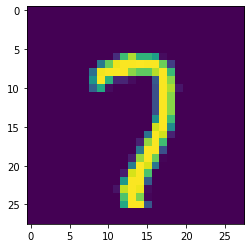

In [25]:
img_clean = input_tensor.cpu().numpy()
plt.imshow(img_clean[0,0])

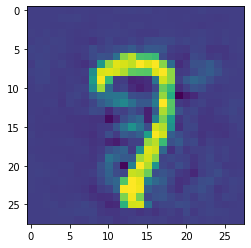

In [26]:
plt.imshow(adversarial_img[0,0])

In [27]:
np.max(adversarial_img)

0.9998784

In [28]:
np.min(adversarial_img)

-0.22995156

In [41]:
pred_input = model(input_tensor)
pred_prob_input = F.softmax(pred_input, dim=1)
print('prediction of adversarial sample: {} with probability: {}'
      .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))

prediction of adversarial sample: 0 with probability: 0.882415235042572


In [40]:
pred_prob_adv = F.softmax(pred_adv, dim=1)
print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))


prediction of adversarial sample: 1 with probability: 0.13421384990215302


In [ ]:
target_onehot_ar = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
target_onehot = torch.from_numpy(target_onehot_ar)
target_onehot = target_onehot.cuda()

output_ar = np.array([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,-2.5990, -0.3694]])
output = torch.from_numpy(output_ar)
output = output.cuda()


In [ ]:
target_onehot

In [ ]:
output

In [ ]:
(target_onehot * output).sum(1)

In [ ]:
real = (target_onehot * output).sum(1)
real

In [ ]:
other = ((1. - target_onehot) * output - target_onehot * 10000.)
other

In [ ]:
other = (other).max(1)[0]
other

In [ ]:
other - real

In [ ]:
torch.clamp(other - real, min=0.)

In [ ]:
# target_onehot:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
# Batch:   0, search step: 0
# output:  tensor([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,
#          -2.5990, -0.3694]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
real:  tensor([-5.3372], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([-0.3694], device='cuda:0', grad_fn=<MaxBackward0>)


In [ ]:
real = (target * output).sum(1)
other = ((1. - target) * output - target * 10000.).max(1)[0]
        